**Dataset**: The dataset from Crunchbase shows characteristics of different companies that were funded all the way from the start of the 20th Century. Each company is labelled either as "closed", "operating" or "acquired"

**Context**: As per our investigation, 90%+ of startups fail in North America, with similar rates all over the world. However, from those that do succeeed, 85% have been acquired. As a result, "acquisition" we aim to understand the variables/characteristics that increases the likelihood of a startup being acquired where Success = Acquired / Failure = Not Acquired

**Scope**: For the scope of this investigation, we will concentrate on acquisitions in the 21st Century (>1999). This will provide more value to our investigation as the business world has changed a lot since the "pre .com" era


| **Column Name**        | **Description**                                                                          |
| ---------------------- | ---------------------------------------------------------------------------------------- |
| `permalink`            | Unique identifier (URL-style) for each company or startup.                               |
| `name`                 | Name of the company or organization.                                                     |
| `homepage_url`         | Official website or homepage of the company.                                             |
| `category_list`        | Industry category or business domain the company belongs to (e.g., FinTech, HealthTech). |
| `market`               | Specific market segment within the broader category.                                     |
| `funding_total_usd`    | Total funding received by the company (in USD).                                          |
| `status`               | Operational status (e.g., operating, acquired, closed, IPO).                             |
| `country_code`         | 3-letter ISO country code of the company’s headquarters (e.g., USA, GBR, CAN).           |
| `state_code`           | Regional or state code (mainly for U.S. companies).                                      |
| `region`               | Broader geographic region of operation (e.g., North America, Europe).                    |
| `city`                 | City where the company is based.                                                         |
| `funding_rounds`       | Number of funding rounds the company has completed.                                      |
| `founded_at`           | Exact founding date of the company (YYYY-MM-DD).                                         |
| `founded_month`        | Month in which the company was founded.                                                  |
| `founded_quarter`      | Quarter in which the company was founded (e.g., Q1, Q2).                                 |
| `founded_year`         | Year the company was founded.                                                            |
| `first_funding_at`     | Date when the company received its first funding.                                        |
| `last_funding_at`      | Date when the company received its most recent funding.                                  |
| `seed`                 | Total amount raised in seed-stage funding.                                               |
| `venture`              | Total amount raised through venture capital funding.                                     |
| `equity_crowdfunding`  | Amount raised via online equity crowdfunding platforms.                                  |
| `undisclosed`          | Funding amount that was reported but not disclosed publicly.                             |
| `convertible_note`     | Amount raised through convertible notes (debt that converts to equity).                  |
| `debt_financing`       | Amount raised via loans or traditional debt instruments.                                 |
| `angel`                | Amount raised from angel investors.                                                      |
| `grant`                | Amount received through grants or non-dilutive funding sources.                          |
| `private_equity`       | Amount raised from private equity firms.                                                 |
| `post_ipo_equity`      | Amount raised from issuing additional shares after going public.                         |
| `post_ipo_debt`        | Amount raised through debt financing after going public.                                 |
| `secondary_market`     | Amount raised from secondary market transactions.                                        |
| `product_crowdfunding` | Amount raised through product-based crowdfunding platforms (e.g., Kickstarter).          |
| `round_A` to `round_H` | Amounts raised in each specific investment round (A, B, C, D, E, F, G, H).               |


## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import RocCurveDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

from ISLP import confusion_table


## Reading Data

In [2]:
investments = pd.read_csv("investments_VC.csv", encoding="latin1",dtype={"funding_total_usd":"string"})
investments.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Remove irrelevant data from DataFrame outside the scope of the investigation (only companies founded in or after 2000)

investments_2000 = investments[investments['founded_year'].ge(2000)].copy()

#Strip column whitespace
investments_2000.columns = investments_2000.columns.str.strip()

print("Rows remaining after filter:", investments_2000.shape[0])
print("Columns:", investments_2000.shape[1])


Rows remaining after filter: 34823
Columns: 39


## EDA

In [4]:
print(investments_2000.columns.to_list())

print("\nThe number of companies of each status: \n")
print(investments_2000['status'].value_counts())

print("\nThe data types are: \n")
print(investments_2000.dtypes)

print("\n The shape is: \n")
print(investments_2000.shape)

print("\n The info is: \n")
print(investments_2000.info())

print("\n The null values per column are: \n")
print(investments_2000.isna().sum())


num_complete_rows = investments_2000.notna().all(axis=1).sum()
print(f"\nThe number of rows with no null values is: {num_complete_rows}")


earliest_founded = min(investments_2000['founded_year'])
latest_founded = max(investments_2000['founded_year'])
print(f"\n The earliest founded year is: {earliest_founded}")
print(f"\n The latest founded year is: {latest_founded}")

['permalink', 'name', 'homepage_url', 'category_list', 'market', 'funding_total_usd', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at', 'last_funding_at', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']

The number of companies of each status: 

status
operating    29776
acquired      2376
closed        1894
Name: count, dtype: int64

The data types are: 

permalink                object
name                     object
homepage_url             object
category_list            object
market                   object
funding_total_usd        object
status                   object
country_code             object
state_code            

In [5]:
total_missing = investments_2000.isna().sum().sum()
total_elements = investments_2000.size
missing_percentage_total = (total_missing / total_elements) * 100
print(f"Percentage of missing values in the whole DataFrame: {missing_percentage_total:.2f}%")

Percentage of missing values in the whole DataFrame: 2.05%


In [6]:
num_duplicates = investments_2000.duplicated().sum()
num_rows = investments_2000.shape[0]
duplicate_percentage = (num_duplicates / num_rows) * 100
print(f"Percentage of duplicate rows in the DataFrame: {duplicate_percentage:.2f}%")

Percentage of duplicate rows in the DataFrame: 0.00%


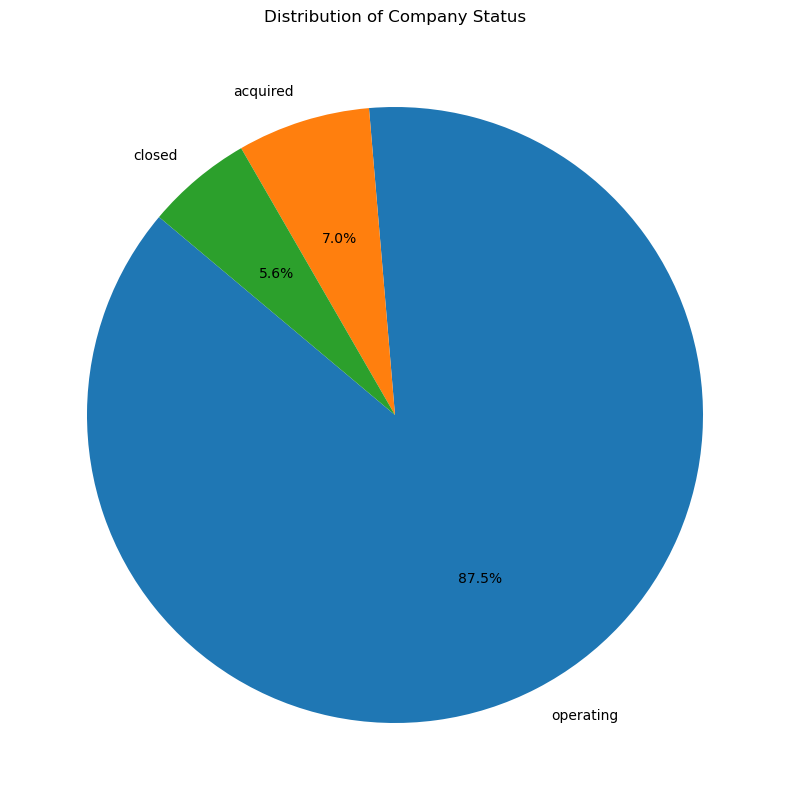

In [7]:
status_counts = investments_2000['status'].value_counts()

# Pie chart
plt.figure(figsize=(10, 10), facecolor='none') # Set figure facecolor to none for transparency
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, textprops={'color':"black"}) # Set text color to white
plt.title('Distribution of Company Status', color='black') # Set title color to white
#plt.savefig('Status_Pie_Chart.png', transparent=True, dpi=300) # Save as PNG with transparent background and 300 dpi
plt.show()

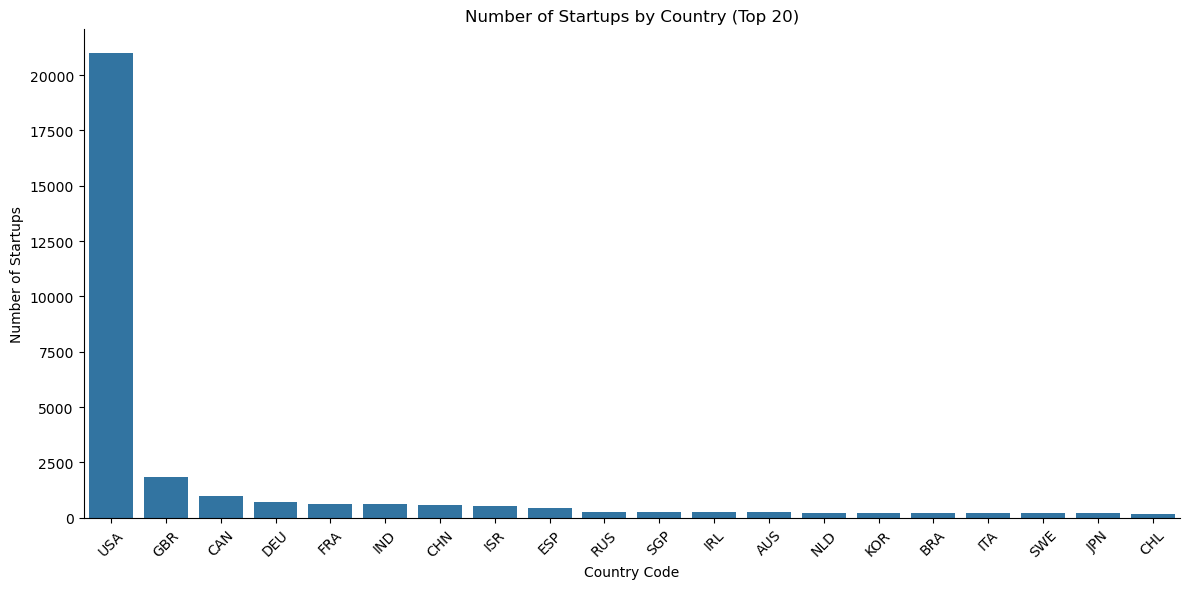

In [8]:
country_counts = investments_2000['country_code'].value_counts().head(20) # Displaying top 20 countries for clarity

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Number of Startups by Country (Top 20)', color='black') # Changed color to black
plt.xlabel('Country Code', color='black') # Changed color to black
plt.ylabel('Number of Startups', color='black') # Changed color to black
plt.xticks(rotation=45, color='black') # Changed color to black
plt.yticks(color='black') # Changed color to black
ax.spines['bottom'].set_color('black') # Changed color to black
ax.spines['left'].set_color('black') # Changed color to black
ax.spines['right'].set_visible(False) # Remove right spine
ax.spines['top'].set_visible(False) # Remove top spine
ax.tick_params(axis='x', colors='black') # Changed color to black
ax.tick_params(axis='y', colors='black') # Changed color to black

plt.tight_layout()
#plt.savefig('Startups_by_country4.png', transparent=True, dpi=300)

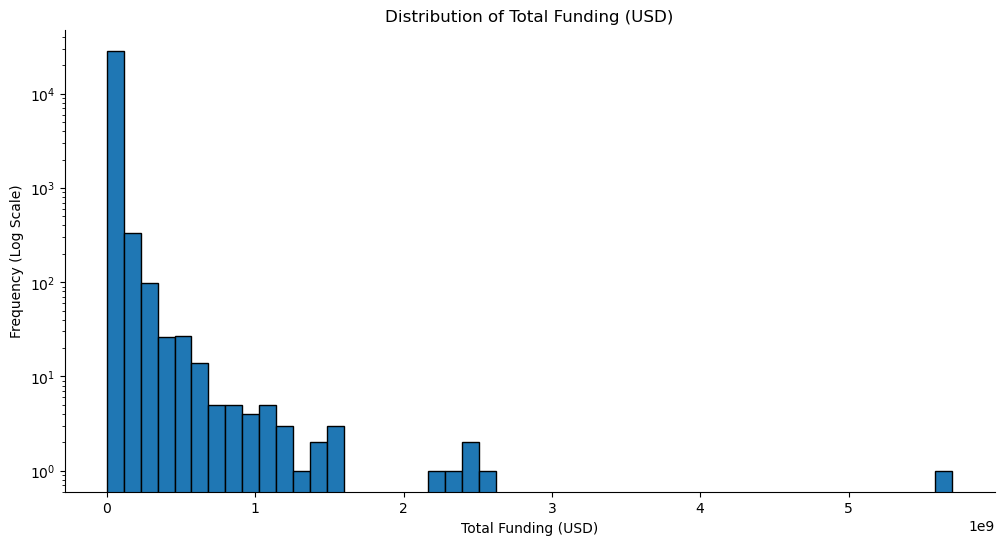

In [9]:
# Clean the ' funding_total_usd ' column
investments_2000['funding_total_usd'] = investments_2000['funding_total_usd'].astype(str).str.replace(',', '', regex=False)
investments_2000['funding_total_usd'] = pd.to_numeric(investments_2000['funding_total_usd'], errors='coerce')

# Drop rows with NaN values in ' funding_total_usd ' after coercion
df_cleaned = investments_2000.dropna(subset=['funding_total_usd'])

# Create the histogram with log scale on y-axis
plt.figure(figsize=(12, 6))
ax = plt.hist(df_cleaned['funding_total_usd'], bins=50, edgecolor='black')
plt.yscale('log') # Set y-axis to log scale
plt.title('Distribution of Total Funding (USD)', color='black')
plt.xlabel('Total Funding (USD)', color='black')
plt.ylabel('Frequency (Log Scale)', color='black')
plt.xticks(color='black')
plt.yticks(color='black')

# Get the axes object to modify spines
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(False) # Remove right spine
ax.spines['top'].set_visible(False) # Remove top spine
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#plt.savefig('Funding_Distribution_Histogram2.png')
plt.show()



 The features that are highly correlated are: 

            Feature1         Feature2  Correlation
110          venture          round_D     0.614847
288  post_ipo_equity    post_ipo_debt     0.698361
311    post_ipo_debt  post_ipo_equity     0.698361
441          round_D          venture     0.614847
528          round_G          round_H     0.859849
551          round_H          round_G     0.859849


[None, None, None, None, None, None, None, None]

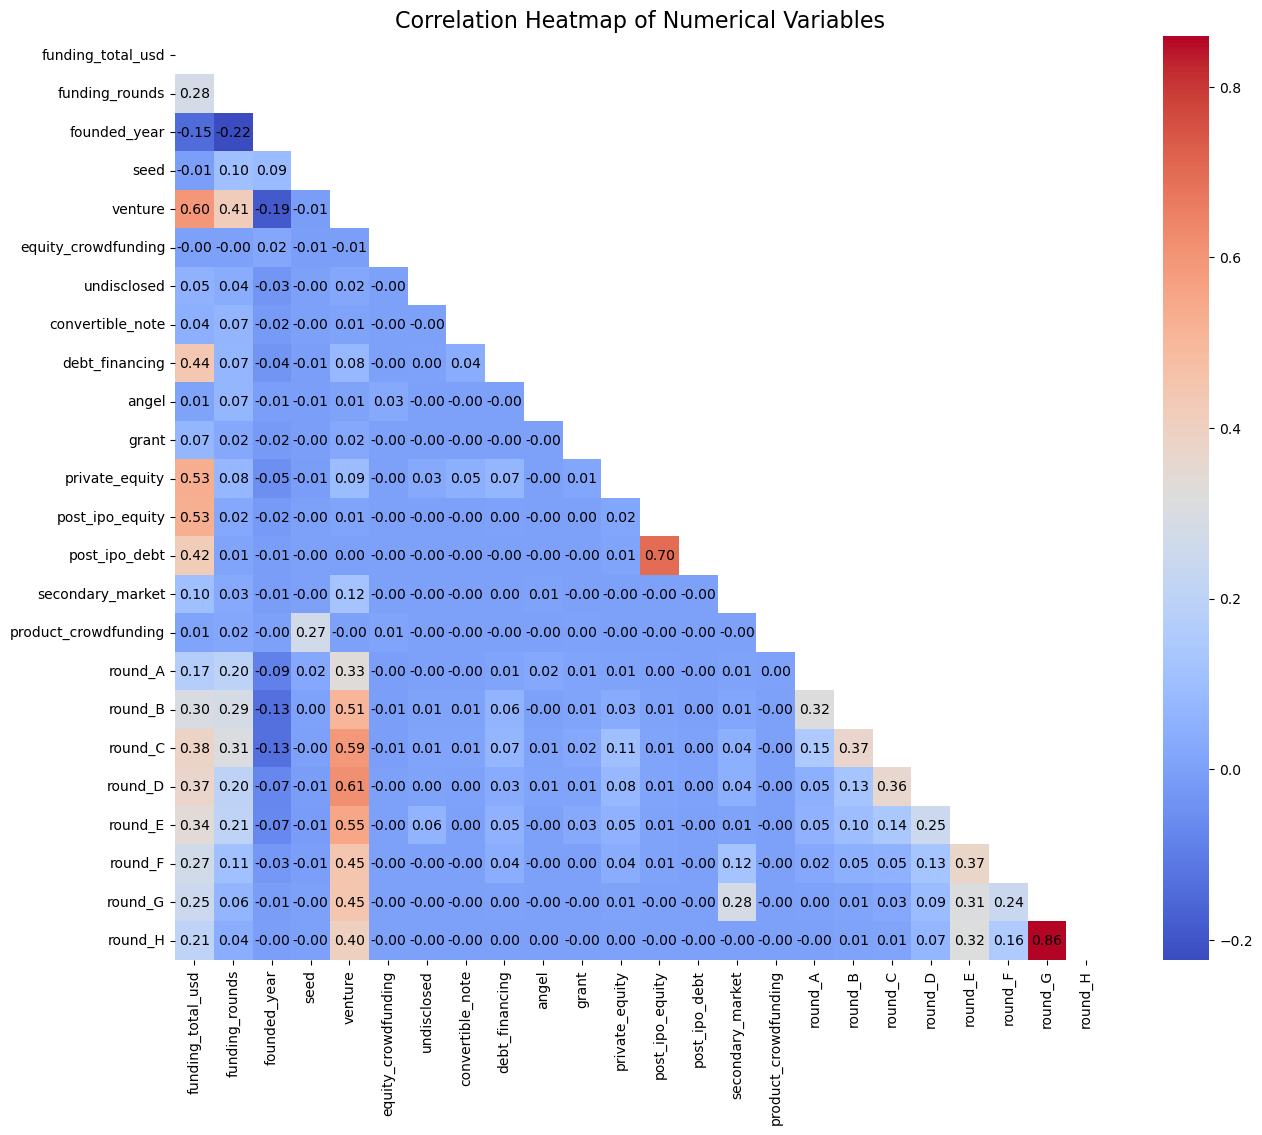

In [10]:
# 1. Calculate Shared Variables (Correlation Matrix)
numeric_cols = investments_2000.select_dtypes(include='number').columns
corr_matrix = investments_2000[numeric_cols].corr()

# 2. Correlation Reporting (Finding Highly Correlated Pairs)
# Remove self-correlations by masking the diagonal
mask_report = np.eye(len(corr_matrix), dtype=bool)
corr_matrix_no_diag = corr_matrix.mask(mask_report)

# Find high correlations
high_corr = corr_matrix_no_diag.stack().reset_index()
high_corr.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = high_corr[abs(high_corr['Correlation']) > 0.6]

print("\n The features that are highly correlated are: \n")
print(high_corr)


# 3. Correlation Plotting (Generating Heatmap)
# Create a mask for the upper triangle (to clean up the plot)
mask_plot = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap with the mask
plt.figure(figsize=(15, 12))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask_plot, annot_kws={"color": "black"}, cbar_kws={"use_gridspec": False, "location": "right"})
plt.title('Correlation Heatmap of Numerical Variables', color='black', fontsize=16)
plt.xticks(color='black')
plt.yticks(color='black')

# Change colorbar text color
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

#plt.savefig('Correlation_Heatmap3.png', transparent=True, dpi=300)

### Chosing relevant columns

**Comment**: There are 39 columns. However only some of these will be relevant to the investigation. We will be removing:

- Metadata: "Permalink", "homepage_url" -> These add no value to our model.
- Irrelevant data: "founded_month","founded_quarter" -> Whether a company was founded in March or December would not explain its success. These attributes are repeated each year and we cant treat October of 1950 the same as October of 2010. These will be removed, and instead "founded_year" will be considered
- Aggregated Data: Funding_total_usd is the sum of column "round a" + ... + "round h". As a result, only Funding_total_USD will be kept, and we will drop the pieces that sum to the total
   
For now, we will keep the following relevant columns: "state_code","market", "funding_total_usd", "country_code", "city", "founded_year", "first_funding_at","last_funding_at", and "status"

Note: While the original dataset includes entries from multiple countries, this investigation will focus exclusively on the United States. Macroeconomic conditions vary significantly across regions so by doing so we are limiting distortion in our data. Also, given that the U.S. serves as a central hub for startup activity, it represents our primary area of interest.

In [11]:
# Extracting relevant columns into new dataset investments_subset 
investments_2000.columns = investments_2000.columns.str.strip()  # removing any potential extra spaces from column names

relevant_cols = ["permalink",
    "state_code",
    "funding_total_usd",
    "founded_year",
    "first_funding_at",
    "last_funding_at",  
    "status",
    "market",
]

# Keep only those columns
investments_subset = investments_2000[relevant_cols].copy()
investments_subset.head()


,permalink,state_code,funding_total_usd,founded_year,first_funding_at,last_funding_at,status,market
0,/organization/waywire,NY,1750000.0,2012.0,2012-06-30,2012-06-30,acquired,News
2,/organization/rock-your-paper,NaN,40000.0,2012.0,2012-08-09,2012-08-09,operating,Publishing
3,/organization/in-touch-network,NaN,1500000.0,2011.0,2011-04-01,2011-04-01,operating,Electronics
4,/organization/r-ranch-and-mine,TX,60000.0,2014.0,2014-08-17,2014-09-26,operating,Tourism
5,/organization/club-domains,FL,7000000.0,2011.0,2013-05-31,2013-05-31,NaN,Software


In [12]:
## Checking size and missing values for investments_subset
subset_shape = investments_subset.shape
null_data_exist_subset = investments_subset.isnull().values.any()
null_data_count_subset = investments_subset.isnull().values.sum()

print('Size of investments_subset data is:', subset_shape)
print('Does investments_subset have missing values?:', null_data_exist_subset)
investments_subset.isnull().sum().sort_values(ascending=False).head(10)


Size of investments_subset data is: (34823, 8)
Does investments_subset have missing values?: True


state_code           12850
funding_total_usd     5741
market                1671
status                 777
permalink                0
founded_year             0
first_funding_at         0
last_funding_at          0
dtype: int64

#### Chosing relevant rows

Missing values:
- State_code: Missing data in this category are because a small subset of data are non-US companies. These will be filtered
- Status and market: Missing values represent <5% of data. They will be dropped. Values missing states are outside of our scope as they are non US companies so those can also be dropped


In [13]:
problem_count = investments[
    (investments['country_code'] == 'USA') &  
    (investments['state_code'].isna())        
].shape[0]

print(f"Number of USA companies with missing state codes: {problem_count}")

# Dropping Missing Values 
investments_subset = investments_subset.dropna().copy()
print("New dataset size:", investments_subset.shape)




Number of USA companies with missing state codes: 26
New dataset size: (17815, 8)


#### Preparing Categorical Data for Analysis

Two of our explanatory variables have a lot of distinct data which would lead to a vast amount of dummy variables, making it messy and not super useful statistically. We will bin these data into identifiable groups. For instance:

- State: To reduce dimensionality in the model and improve interpretability, the 50 U.S. states are grouped based on their Business-friendly Index as per the trusted 2024 Tax Foundation State Business Tax Climate Index. This provides value in explaining which states provide the best environment for a start up to be acquired. 
- Market: We condensed the markets into a smaller set of broader industry groups to avoid creating too many dummy variables, which would slow down the model and cause memory issues. For example, instead of treating “Software,” “Enterprise Software,” and “SaaS” as separate categories, we combined them into one Software & IT group, helping us reduce 35+ industries down to 7.

In [14]:
#Grouping States
investments_subset['state_code'] = investments_subset['state_code'].str.strip()

# 2014 State Business Tax Climate Index tiers
# Tier 1 (1–15): Business_Friendly
# Tier 2 (16–35): Moderate
# Tier 3 (36–50): High_Regulation

business_groups = {
    # Tier 1 — Business_Friendly (ranks 1–15 in 2014)
    'WY':'Business_Friendly','SD':'Business_Friendly','NV':'Business_Friendly','AK':'Business_Friendly',
    'FL':'Business_Friendly','MT':'Business_Friendly','UT':'Business_Friendly','NH':'Business_Friendly',
    'OR':'Business_Friendly','IN':'Business_Friendly','MI':'Business_Friendly','TX':'Business_Friendly',
    'WA':'Business_Friendly','MO':'Business_Friendly','ID':'Business_Friendly',

    # Tier 2 — Moderate (ranks 16–35 in 2014)
    'VA':'Moderate','WV':'Moderate','DE':'Moderate','ND':'Moderate','OK':'Moderate','NM':'Moderate',
    'KS':'Moderate','CO':'Moderate','TN':'Moderate','MS':'Moderate','MA':'Moderate','AZ':'Moderate',
    'GA':'Moderate','KY':'Moderate','LA':'Moderate','ME':'Moderate','IL':'Moderate','NC':'Moderate',
    'SC':'Moderate','WI':'Moderate',

    # Tier 3 — High_Regulation (ranks 36–50 in 2014)
    'NE':'High_Regulation','AL':'High_Regulation','AR':'High_Regulation','CA':'High_Regulation',
    'CT':'High_Regulation','HI':'High_Regulation','IA':'High_Regulation','MD':'High_Regulation',
    'MN':'High_Regulation','NJ':'High_Regulation','NY':'High_Regulation','OH':'High_Regulation',
    'PA':'High_Regulation','RI':'High_Regulation','VT':'High_Regulation',
    'DC':'High_Regulation'
}


investments_subset['state_code'] = investments_subset['state_code'].map(business_groups).fillna('Other')

#Grouping markets

# Grouping Markets into Buckets

investments_subset['market'] = investments_subset['market'].str.strip()
bucket_mapping = {
    # Tier 1 - Media & Entertainment
    'News':'Media & Entertainment', 'Games':'Media & Entertainment', 'Publishing':'Media & Entertainment',
    'Advertising':'Media & Entertainment', 'Curated Web':'Media & Entertainment', 'Social Travel':'Media & Entertainment',
    'Sports':'Media & Entertainment', 'Chat':'Media & Entertainment', 'Video Chat':'Media & Entertainment',
    'Social Media':'Media & Entertainment', 'Photography':'Media & Entertainment', 'Art':'Media & Entertainment',
    'Blogging Platforms':'Media & Entertainment', 'Mobile Social':'Media & Entertainment', 'Messaging':'Media & Entertainment',
    'Mobile Games':'Media & Entertainment', 'Social Games':'Media & Entertainment', 'Communities':'Media & Entertainment',
    'Social Network Media':'Media & Entertainment', 'Digital Media':'Media & Entertainment', 'Social Bookmarking':'Media & Entertainment',
    'Content Syndication':'Media & Entertainment', 'Broadcasting':'Media & Entertainment', 'Opinions':'Media & Entertainment',
    'Content':'Media & Entertainment', 'Content Creators':'Media & Entertainment', 'Social + Mobile + Local':'Media & Entertainment',
    'Video Streaming':'Media & Entertainment', 'Photo Sharing':'Media & Entertainment', 'Video':'Media & Entertainment',
    'Music':'Media & Entertainment', 'Game':'Media & Entertainment', 'Entertainment':'Media & Entertainment',
    'Digital Entertainment':'Media & Entertainment', 'Virtual Worlds':'Media & Entertainment', 'Television':'Media & Entertainment',
    'Social Media Platforms':'Media & Entertainment', 'Internet Radio Market':'Media & Entertainment', 'E-Books':'Media & Entertainment',
    'Forums':'Media & Entertainment', 'Private Social Networking':'Media & Entertainment', 'Social News':'Media & Entertainment',
    'Politics':'Media & Entertainment', 'MicroBlogging':'Media & Entertainment', 'Celebrity':'Media & Entertainment',
    'Artists Globally':'Media & Entertainment', 'Religion':'Media & Entertainment', 'Theatre':'Media & Entertainment',
    'Independent Music Labels':'Media & Entertainment', 'Q&A':'Media & Entertainment', 'Concerts':'Media & Entertainment',
    'Film Distribution':'Media & Entertainment', 'TV Production':'Media & Entertainment', 'Internet TV':'Media & Entertainment',
    'Musical Instruments':'Media & Entertainment', 'Racing':'Media & Entertainment', 'Swimming':'Media & Entertainment',
    'Social Television':'Media & Entertainment', 'Comics':'Media & Entertainment', 'FreetoPlay Gaming':'Media & Entertainment',
    'Musicians':'Media & Entertainment', 'Mobile Video':'Media & Entertainment', 'Cloud-Based Music':'Media & Entertainment',
    'SNS':'Media & Entertainment', 'Performing Arts':'Media & Entertainment', 'Contests':'Media & Entertainment',
    'Music Venues':'Media & Entertainment', 'Email Newsletters':'Media & Entertainment', 'Writers':'Media & Entertainment',
    'Social Opinion Platform':'Media & Entertainment', 'Reading Apps':'Media & Entertainment', 'EBooks':'Media & Entertainment',
    'Video Games':'Media & Entertainment', 'Film Production':'Media & Entertainment', 'Music Services':'Media & Entertainment',
    'MMO Games':'Media & Entertainment', 'Fantasy Sports':'Media & Entertainment', 'Gambling':'Media & Entertainment',
    'Game Mechanics':'Media & Entertainment', 'Content Discovery':'Media & Entertainment', 'Soccer':'Media & Entertainment',
    'In-Flight Entertainment':'Media & Entertainment', 'Casual Games':'Media & Entertainment', 'Entertainment Industry':'Media & Entertainment',
    'Educational Games':'Media & Entertainment', 'PC Gaming':'Media & Entertainment', 'Film':'Media & Entertainment',
    'Journalism':'Media & Entertainment', 'Guides':'Media & Entertainment', 'Audio':'Media & Entertainment',
    'Online Gaming':'Media & Entertainment', 'Video on Demand':'Media & Entertainment', 'Video Processing':'Media & Entertainment',
    'Smart Grid':'Media & Entertainment', 'Charter Schools':'Media & Entertainment', 'Radical Breakthrough Startups':'Media & Entertainment',
    'Social Business':'Media & Entertainment', 'Social Innovation':'Media & Entertainment', 'Startups':'Media & Entertainment',
    'Smart Building':'Media & Entertainment', 'Social Commerce':'Media & Entertainment', 'Social Buying':'Media & Entertainment',
    'Online Video Advertising':'Media & Entertainment',

    # Tier 2 - Technology & Software
    'Software':'Technology & Software', 'Health Care Information Technology':'Technology & Software', 'Analytics':'Technology & Software',
    'Mobile':'Technology & Software', 'SaaS':'Technology & Software', 'Enterprise Software':'Technology & Software',
    'File Sharing':'Technology & Software', 'Mobile Security':'Technology & Software', 'Predictive Analytics':'Technology & Software',
    'Big Data':'Technology & Software', 'Hardware + Software':'Technology & Software', 'Corporate IT':'Technology & Software',
    'Web Development':'Technology & Software', '3D Printing':'Technology & Software', '3D':'Technology & Software',
    '3D Technology':'Technology & Software', 'Drones':'Technology & Software', 'Semiconductors':'Technology & Software',
    'Web Hosting':'Technology & Software', 'Android':'Technology & Software', 'Developer APIs':'Technology & Software',
    'Security':'Technology & Software', 'Flash Storage':'Technology & Software', 'Networking':'Technology & Software',
    'Machine Learning':'Technology & Software', 'Web Design':'Technology & Software', 'Cloud Computing':'Technology & Software',
    'Interface Design':'Technology & Software', 'Technology':'Technology & Software', 'Telecommunications':'Technology & Software',
    'Twitter Applications':'Technology & Software', 'Business Productivity':'Technology & Software', 'Communications Hardware':'Technology & Software',
    'EDA Tools':'Technology & Software', 'Virtualization':'Technology & Software', 'Cloud Infrastructure':'Technology & Software',
    'M2M':'Technology & Software', 'Identity Management':'Technology & Software', 'Information Security':'Technology & Software',
    'Apps':'Technology & Software', 'Information Technology':'Technology & Software', 'Medical Devices':'Technology & Software',
    'Cloud Management':'Technology & Software', 'Vertical Search':'Technology & Software', 'Internet of Things':'Technology & Software',
    'Semantic Search':'Technology & Software', 'Internet':'Technology & Software', 'Business Intelligence':'Technology & Software',
    'Email':'Technology & Software', 'Development Platforms':'Technology & Software', 'Semantic Web':'Technology & Software',
    'Collaboration':'Technology & Software', 'Assisitive Technology':'Technology & Software', 'Facebook Applications':'Technology & Software',
    'Location Based Services':'Technology & Software', 'Trusted Networks':'Technology & Software', 'Data Visualization':'Technology & Software',
    'Enterprise Search':'Technology & Software', 'Optimization':'Technology & Software', 'Application Platforms':'Technology & Software',
    'Computers':'Technology & Software', 'Real Time':'Technology & Software', 'Digital Signage':'Technology & Software',
    'RIM':'Technology & Software', 'Databases':'Technology & Software', 'Displays':'Technology & Software',
    'Meeting Software':'Technology & Software', 'Retail Technology':'Technology & Software', 'Tablets':'Technology & Software',
    'Gps':'Technology & Software', 'Web CMS':'Technology & Software', 'Sensors':'Technology & Software',
    'iPhone':'Technology & Software', 'Human Computer Interaction':'Technology & Software', 'Local Search':'Technology & Software',
    'Computer Vision':'Technology & Software', 'Cloud Security':'Technology & Software', 'Credit':'Technology & Software',
    'Document Management':'Technology & Software', 'Data Mining':'Technology & Software', 'Linux':'Technology & Software',
    'App Stores':'Technology & Software', 'Open Source':'Technology & Software', 'iPad':'Technology & Software',
    'Big Data Analytics':'Technology & Software', 'Data Integration':'Technology & Software', 'College Recruiting':'Technology & Software',
    'Knowledge Management':'Technology & Software', 'Social Media Monitoring':'Technology & Software', 'Portals':'Technology & Software',
    'Graphics':'Technology & Software', 'Mobile Software Tools':'Technology & Software', 'Enterprise Security':'Technology & Software',
    'Mobile Enterprise':'Technology & Software', 'Homeland Security':'Technology & Software', 'Mobile Devices':'Technology & Software',
    'Developer Tools':'Technology & Software', 'PaaS':'Technology & Software', 'Application Performance Monitoring':'Technology & Software',
    'Testing':'Technology & Software', 'User Experience Design':'Technology & Software', 'QR Codes':'Technology & Software',
    'Cyber Security':'Technology & Software', 'CRM':'Technology & Software', 'Enterprise Application':'Technology & Software',
    'Browser Extensions':'Technology & Software', 'Contact Management':'Technology & Software', 'Data Security':'Technology & Software',
    'Deep Information Technology':'Technology & Software', 'Augmented Reality':'Technology & Software', 'Universities':'Technology & Software',
    'Web Tools':'Technology & Software', 'Visualization':'Technology & Software', 'Physical Security':'Technology & Software',
    'Identity':'Technology & Software', 'Tracking':'Technology & Software', 'RFID':'Technology & Software',
    'E-Commerce Platforms':'Technology & Software', 'Productivity Software':'Technology & Software', 'NFC':'Technology & Software',
    'Content Delivery':'Technology & Software', 'Video Conferencing':'Technology & Software', 'Network Security':'Technology & Software',
    'VoIP':'Technology & Software', 'Storage':'Technology & Software', 'Social Search':'Technology & Software',
    'Peer-to-Peer':'Technology & Software', 'Project Management':'Technology & Software', 'Data Privacy':'Technology & Software',
    'Algorithms':'Technology & Software', 'IT and Cybersecurity':'Technology & Software', 'Biometrics':'Technology & Software',
    'High Tech':'Technology & Software', 'Enterprise Hardware':'Technology & Software', 'Infrastructure':'Technology & Software',
    'Data Centers':'Technology & Software', 'Image Recognition':'Technology & Software', 'IaaS':'Technology & Software',
    'Credit Cards':'Technology & Software', 'CAD':'Technology & Software', 'Ediscovery':'Technology & Software',
    'University Students':'Technology & Software', 'Customer Support Tools':'Technology & Software', 'Proximity Internet':'Technology & Software',
    'Tech Field Support':'Technology & Software', 'Text Analytics':'Technology & Software', 'Embedded Hardware and Software':'Technology & Software',
    'Bridging Online and Offline':'Technology & Software', 'Synchronization':'Technology & Software', 'Utilities':'Technology & Software',
    'Digital Rights Management':'Technology & Software', 'Communications Infrastructure':'Technology & Software', 'Systems':'Technology & Software',
    'Senior Citizens':'Technology & Software', 'Architecture':'Technology & Software', 'Google Apps':'Technology & Software',
    'Social Recruiting':'Technology & Software', 'WebOS':'Technology & Software', 'Natural Language Processing':'Technology & Software',
    'Windows Phone 7':'Technology & Software', 'New Product Development':'Technology & Software', 'Supply Chain Management':'Technology & Software',
    'Indoor Positioning':'Technology & Software', 'Usability':'Technology & Software', 'Domains':'Technology & Software',
    'Software Compliance':'Technology & Software', 'Registrars':'Technology & Software', 'App Discovery':'Technology & Software',
    'Motion Capture':'Technology & Software', 'Intelligent Systems':'Technology & Software', 'China Internet':'Technology & Software',
    'New Technologies':'Technology & Software', 'Point of Sale':'Technology & Software', 'Data Center Infrastructure':'Technology & Software',
    'Unmanned Air Systems':'Technology & Software', 'Business Information Systems':'Technology & Software', 'Commodities':'Technology & Software',
    'Speech Recognition':'Technology & Software', 'Face Recognition':'Technology & Software', 'ICT':'Technology & Software',
    'Self Development':'Technology & Software', 'Kinect':'Technology & Software', 'Web Browsers':'Technology & Software',
    'Presentations':'Technology & Software', 'Internet Service Providers':'Technology & Software', 'Rapidly Expanding':'Technology & Software',
    'Video Editing':'Technology & Software', 'Biotechnology and Semiconductor':'Technology & Software', 'Visual Search':'Technology & Software',
    'Internet Infrastructure':'Technology & Software', 'Cyber':'Technology & Software', 'Group SMS':'Technology & Software',
    'Lasers':'Technology & Software', 'Weird Hardware':'Technology & Software', 'Energy IT':'Technology & Software',
    'Mac':'Technology & Software', 'Renewable Tech':'Technology & Software', 'Enterprise 2.0':'Technology & Software',
    'Photo Editing':'Technology & Software', 'Google Glass':'Technology & Software', 'Mobile Infrastructure':'Technology & Software',
    'Data Center Automation':'Technology & Software', 'Personal Data':'Technology & Software', 'Internet Technology':'Technology & Software',
    'Fraud Detection':'Technology & Software', 'Quantitative Marketing':'Technology & Software', 'Online Identity':'Technology & Software',
    'Gadget':'Technology & Software', 'Early-Stage Technology':'Technology & Software', 'Simulation':'Technology & Software',
    'Test and Measurement':'Technology & Software', 'Automated Kiosk':'Technology & Software', 'Clean Technology IT':'Technology & Software',
    'Finance Technology':'Technology & Software', 'Mobile Analytics':'Technology & Software', 'Cloud Data Services':'Technology & Software',
    'Privacy':'Technology & Software', 'SMS':'Technology & Software', 'Artificial Intelligence':'Technology & Software',
    'Bitcoin':'Technology & Software', 'Navigation':'Technology & Software', 'Maps':'Technology & Software',
    'Nanotechnology':'Technology & Software', 'Mining Technologies':'Technology & Software', 'Nonprofits':'Technology & Software',
    'Recruiting':'Technology & Software', 'Advertising Platforms':'Technology & Software', 'Email Marketing':'Technology & Software',
    'Social CRM':'Technology & Software', 'Hardware':'Technology & Software', 'IT Management':'Technology & Software',
    'Charity':'Technology & Software', 'Employer Benefits Programs':'Technology & Software', 'Nutrition':'Technology & Software',
    'Sustainability':'Technology & Software', 'Non Profit':'Technology & Software', 'Venture Capital':'Technology & Software',
    'Search':'Technology & Software', 'Gamification':'Technology & Software', 'Fitness':'Technology & Software',
    'Retail':'Technology & Software', 'DOD/Military':'Technology & Software', 'Product Development Services':'Technology & Software',
    'Specialty Retail':'Technology & Software', 'Hospitals':'Technology & Software', 'Wireless':'Technology & Software',

    # Tier 3 - Business Services
    'Designers':'Business Services', 'Sales and Marketing':'Business Services', 'Services':'Business Services',
    'Outsourcing':'Business Services', 'Customer Service':'Business Services', 'Human Resources':'Business Services',
    'Entrepreneur':'Business Services', 'Business Services':'Business Services', 'Career Management':'Business Services',
    'Small and Medium Businesses':'Business Services', 'SEO':'Business Services', 'Task Management':'Business Services',
    'Public Relations':'Business Services', 'Consulting':'Business Services', 'Design':'Business Services',
    'Creative':'Business Services', 'Events':'Business Services', 'Brand Marketing':'Business Services',
    'Ad Targeting':'Business Services', 'Social Media Advertising':'Business Services', 'Lead Generation':'Business Services',
    'Online Scheduling':'Business Services', 'Outdoor Advertising':'Business Services', 'App Marketing':'Business Services',
    'Legal':'Business Services', 'Advice':'Business Services', 'Advertising Exchanges':'Business Services',
    'Business Development':'Business Services', 'Personal Branding':'Business Services', 'Crowdsourcing':'Business Services',
    'Information Services':'Business Services', 'Product Design':'Business Services', 'Enterprises':'Business Services',
    'BPO Services':'Business Services', 'Reputation':'Business Services', 'Training':'Business Services',
    'Loyalty Programs':'Business Services', 'Social Media Marketing':'Business Services', 'Freelancers':'Business Services',
    'Market Research':'Business Services', 'Service Providers':'Business Services', 'Professional Services':'Business Services',
    'Local Advertising':'Business Services', 'Creative Industries':'Business Services', 'Direct Marketing':'Business Services',
    'Consumer Behavior':'Business Services', 'Incubators':'Business Services', 'Coworking':'Business Services',
    'Career Planning':'Business Services', 'World Domination':'Business Services', 'Moneymaking':'Business Services',
    'Intellectual Property':'Business Services', 'Printing':'Business Services', 'Staffing Firms':'Business Services',
    'All Markets':'Business Services', 'Employment':'Business Services', 'Shared Services':'Business Services',
    'Governments':'Business Services', 'Engineering Firms':'Business Services', 'Professional Networking':'Business Services',
    'Ventures for Good':'Business Services', 'Procurement':'Business Services', 'Law Enforcement':'Business Services',
    'Funeral Industry':'Business Services', 'Freemium':'Business Services', 'Interior Design':'Business Services',
    'Skill Assessment':'Business Services', 'Innovation Management':'Business Services', 'Public Safety':'Business Services',
    'Polling':'Business Services', 'Humanitarian':'Business Services', 'Surveys':'Business Services',
    'Contact Centers':'Business Services', 'Human Resource Automation':'Business Services', 'Call Center Automation':'Business Services',
    'Innovation Engineering':'Business Services', 'Lifestyle Businesses':'Business Services', 'Offline Businesses':'Business Services',
    'Governance':'Business Services', 'Demographies':'Business Services', 'Homeless Shelter':'Business Services',
    'Government Innovation':'Business Services', 'Niche Specific':'Business Services', 'Web Presence Management':'Business Services',
    'Franchises':'Business Services', 'Social Media Agent':'Business Services', 'Enterprise Purchasing':'Business Services',
    'Estimation and Quoting':'Business Services', 'Multi-level Marketing':'Business Services', 'Service Industries':'Business Services',
    'Internet Marketing':'Business Services', 'Promotional':'Business Services', 'Search Marketing':'Business Services',
    'Mobile Advertising':'Business Services', 'Lead Management':'Business Services', 'Performance Marketing':'Business Services',
    'Advertising Networks':'Business Services', 'Civil Engineers':'Business Services', 'Translation':'Business Services',
    'Corporate Training':'Business Services', 'Sales Automation':'Business Services', 'Sponsorship':'Business Services',
    'Intellectual Asset Management':'Business Services', 'Event Management':'Business Services',

    # Tier 4 - Consumer & Retail
    'Electronics':'Consumer & Retail', 'E-Commerce':'Consumer & Retail', 'Marketplaces':'Consumer & Retail',
    'Restaurants':'Consumer & Retail', 'Fashion':'Consumer & Retail', 'Mobile Commerce':'Consumer & Retail',
    'Lifestyle':'Consumer & Retail', 'Wine And Spirits':'Consumer & Retail', 'Consumer Electronics':'Consumer & Retail',
    'Kids':'Consumer & Retail', 'Pets':'Consumer & Retail', 'Women':'Consumer & Retail',
    'Specialty Foods':'Consumer & Retail', 'Online Shopping':'Consumer & Retail', 'Coupons':'Consumer & Retail',
    'Collectibles':'Consumer & Retail', 'Classifieds':'Consumer & Retail', 'Auctions':'Consumer & Retail',
    'Comparison Shopping':'Consumer & Retail', 'Consumers':'Consumer & Retail', 'Shopping':'Consumer & Retail',
    'Match-Making':'Consumer & Retail', 'Online Rental':'Consumer & Retail', 'Groceries':'Consumer & Retail',
    'Weddings':'Consumer & Retail', 'Lighting':'Consumer & Retail', 'Craft Beer':'Consumer & Retail',
    'Craigslist Killers':'Consumer & Retail', 'Consumer Goods':'Consumer & Retail', 'Reviews and Recommendations':'Consumer & Retail',
    'Toys':'Consumer & Retail', 'Handmade':'Consumer & Retail', 'Online Dating':'Consumer & Retail',
    'Consumer Internet':'Consumer & Retail', 'Subscription Businesses':'Consumer & Retail', 'Ticketing':'Consumer & Retail',
    'Babies':'Consumer & Retail', 'Price Comparison':'Consumer & Retail', 'Group Buying':'Consumer & Retail',
    'Jewelry':'Consumer & Retail', 'Home Decor':'Consumer & Retail', 'Wholesale':'Consumer & Retail',
    'Farmers Market':'Consumer & Retail', 'Baby Accessories':'Consumer & Retail', 'Parenting':'Consumer & Retail',
    'Lifestyle Products':'Consumer & Retail', 'Discounts':'Consumer & Retail', 'Organic':'Consumer & Retail',
    'Collaborative Consumption':'Consumer & Retail', 'Organic Food':'Consumer & Retail', 'Low Bid Auctions':'Consumer & Retail',
    'Shoes':'Consumer & Retail', 'Teenagers':'Consumer & Retail', 'Cosmetics':'Consumer & Retail',
    'General Public Worldwide':'Consumer & Retail', 'Flowers':'Consumer & Retail', 'Flash Sales':'Consumer & Retail',
    'Cooking':'Consumer & Retail', 'Coffee':'Consumer & Retail', 'Leisure':'Consumer & Retail',
    'Gift Card':'Consumer & Retail', 'Nightlife':'Consumer & Retail', 'Home Renovation':'Consumer & Retail',
    'Nightclubs':'Consumer & Retail', 'Recipes':'Consumer & Retail', 'Mobile Coupons':'Consumer & Retail',
    'Sex':'Consumer & Retail', 'Product Search':'Consumer & Retail', 'Sporting Goods':'Consumer & Retail',
    'Local Coupons':'Consumer & Retail', 'Debt Collecting':'Consumer & Retail', 'Doctors':'Consumer & Retail',
    'Wealth Management':'Consumer & Retail', 'Transaction Processing':'Consumer & Retail', 'Eyewear':'Consumer & Retail',
    'Green Consumer Goods':'Consumer & Retail', 'Retirement':'Consumer & Retail', 'Online Auctions':'Consumer & Retail',
    'Recreation':'Consumer & Retail', 'Bicycles':'Consumer & Retail', 'Vacation Rentals':'Consumer & Retail',
    'Virtual Goods':'Consumer & Retail', 'Families':'Consumer & Retail', 'Twin-Tip Skis':'Consumer & Retail',
    'Lotteries':'Consumer & Retail', 'DIY':'Consumer & Retail', 'Gift Exchange':'Consumer & Retail',
    'Home Owners':'Consumer & Retail', 'Sunglasses':'Consumer & Retail', 'Lingerie':'Consumer & Retail',
    'Tea':'Consumer & Retail', 'Young Adults':'Consumer & Retail', 'Vending and Concessions':'Consumer & Retail',
    'Baby Boomers':'Consumer & Retail', 'Timeshares':'Consumer & Retail', 'Beauty':'Consumer & Retail',
    'Home Automation':'Consumer & Retail', 'Home & Garden':'Consumer & Retail', 'Consumer Lending':'Consumer & Retail',
    'Food Processing':'Consumer & Retail', 'Direct Sales':'Consumer & Retail', 'Mobile Shopping':'Consumer & Retail',
    'Golf Equipment':'Consumer & Retail',

    # Tier 5 - Health & Wellness
    'Health and Wellness':'Health & Wellness', 'Personal Health':'Health & Wellness', 'Mobile Health':'Health & Wellness',
    'Health Care':'Health & Wellness', 'Medical':'Health & Wellness', 'Biotechnology':'Health & Wellness',
    'Pharmaceuticals':'Health & Wellness', 'Life Sciences':'Health & Wellness', 'Physicians':'Health & Wellness',
    'Electronic Health Records':'Health & Wellness', 'Exercise':'Health & Wellness', 'Healthcare Services':'Health & Wellness',
    'Bio-Pharm':'Health & Wellness', 'Health Services Industry':'Health & Wellness', 'Psychology':'Health & Wellness',
    'Alternative Medicine':'Health & Wellness', 'Genetic Testing':'Health & Wellness', 'Dental':'Health & Wellness',
    'Diabetes':'Health & Wellness', 'Diagnostics':'Health & Wellness', 'Neuroscience':'Health & Wellness',
    'Medical Professionals':'Health & Wellness', 'mHealth':'Health & Wellness', 'Synthetic Biology':'Health & Wellness',
    'Spas':'Health & Wellness', 'Medical Marijuana Patients':'Health & Wellness', 'Elder Care':'Health & Wellness',
    'Remediation':'Health & Wellness', 'Clinical Trials':'Health & Wellness', 'Veterinary':'Health & Wellness',
    'Cosmetic Surgery':'Health & Wellness', 'Rehabilitation':'Health & Wellness', 'Senior Health':'Health & Wellness',
    'Dietary Supplements':'Health & Wellness', 'Therapeutics':'Health & Wellness', 'Bioinformatics':'Health & Wellness',
    'Corporate Wellness':'Health & Wellness', 'Mobile Emergency&Health':'Health & Wellness', 'Quantified Self':'Health & Wellness',
    'Social Media Management':'Health & Wellness',

    # Tier 6 - Finance & Insurance
    'Finance':'Finance & Insurance', 'Financial Services':'Finance & Insurance', 'Social Fundraising':'Finance & Insurance',
    'Payments':'Finance & Insurance', 'Mobile Payments':'Finance & Insurance', 'Accounting':'Finance & Insurance',
    'P2P Money Transfer':'Finance & Insurance', 'Personal Finance':'Finance & Insurance', 'Insurance':'Finance & Insurance',
    'Banking':'Finance & Insurance', 'Stock Exchanges':'Finance & Insurance', 'Financial Exchanges':'Finance & Insurance',
    'Trading':'Finance & Insurance', 'Virtual Currency':'Finance & Insurance', 'Investment Management':'Finance & Insurance',
    'Crowdfunding':'Finance & Insurance', 'Real Estate Investors':'Finance & Insurance', 'Angels':'Finance & Insurance',
    'Risk Management':'Finance & Insurance', 'Billing':'Finance & Insurance', 'Emerging Markets':'Finance & Insurance',
    'Health and Insurance':'Finance & Insurance', 'Gold':'Finance & Insurance', 'Insurance Companies':'Finance & Insurance',
    'Resorts':'Finance & Insurance', 'Hedge Funds':'Finance & Insurance', 'Social Investing':'Finance & Insurance',
    'Brokers':'Finance & Insurance',

    # Tier 7 - Real Estate & Local Services
    'Real Estate':'Real Estate & Local Services', 'Local Businesses':'Real Estate & Local Services', 'Commercial Real Estate':'Real Estate & Local Services',
    'Local Based Services':'Real Estate & Local Services', 'Construction':'Real Estate & Local Services', 'Office Space':'Real Estate & Local Services',
    'Local':'Real Estate & Local Services', 'Rental Housing':'Real Estate & Local Services', 'Property Management':'Real Estate & Local Services',
    'Local Commerce':'Real Estate & Local Services', 'Plumbers':'Real Estate & Local Services', 'Infrastructure Builders':'Real Estate & Local Services',
    'Realtors':'Real Estate & Local Services', 'Self Storage':'Real Estate & Local Services', 'Green Building':'Real Estate & Local Services',

    # Tier 8 - Industrial & Energy
    'Tourism':'Industrial & Energy', 'Mobility':'Industrial & Energy', 'Manufacturing':'Industrial & Energy',
    'Travel':'Industrial & Energy', 'Hospitality':'Industrial & Energy', 'Transportation':'Industrial & Energy',
    'Clean Technology':'Industrial & Energy', 'Carbon':'Industrial & Energy', 'Distribution':'Industrial & Energy',
    'Online Travel':'Industrial & Energy', 'Automotive':'Industrial & Energy', 'Batteries':'Industrial & Energy',
    'Solar':'Industrial & Energy', 'Water Purification':'Industrial & Energy', 'Travel & Tourism':'Industrial & Energy',
    'Adventure Travel':'Industrial & Energy', 'Defense':'Industrial & Energy', 'Aerospace':'Industrial & Energy',
    'Energy':'Industrial & Energy', 'Agriculture':'Industrial & Energy', 'Recycling':'Industrial & Energy',
    'Public Transportation':'Industrial & Energy', 'Biomass Power Generation':'Industrial & Energy', 'Distributors':'Industrial & Energy',
    'Animal Feed':'Industrial & Energy', 'Renewable Energies':'Industrial & Energy', 'Material Science':'Industrial & Energy',
    'Logistics':'Industrial & Energy', 'Chemicals':'Industrial & Energy', 'Robotics':'Industrial & Energy',
    'Oil':'Industrial & Energy', 'Oil & Gas':'Industrial & Energy', 'Oil and Gas':'Industrial & Energy',
    'Logistics Company':'Industrial & Energy', 'Industrial Automation':'Industrial & Energy', 'Natural Resources':'Industrial & Energy',
    'Minerals':'Industrial & Energy', 'Water':'Industrial & Energy', 'Boating Industry':'Industrial & Energy',
    'Textiles':'Industrial & Energy', 'Hotels':'Industrial & Energy', 'Taxis':'Industrial & Energy',
    'Auto':'Industrial & Energy', 'Parking':'Industrial & Energy', 'Environmental Innovation':'Industrial & Energy',
    'Advanced Materials':'Industrial & Energy', 'Motors':'Industrial & Energy', 'Farming':'Industrial & Energy',
    'Electrical Distribution':'Industrial & Energy', 'Energy Efficiency':'Industrial & Energy', 'Electric Vehicles':'Industrial & Energy',
    'Fleet Management':'Industrial & Energy', 'Green':'Industrial & Energy', 'Residential Solar':'Industrial & Energy',
    'Shipping':'Industrial & Energy', 'Heavy Industry':'Industrial & Energy', 'B2B Express Delivery':'Industrial & Energy',
    'Commercial Solar':'Industrial & Energy', 'Mechanical Solutions':'Industrial & Energy', 'Natural Gas Uses':'Industrial & Energy',
    'Industrial Energy Efficiency':'Industrial & Energy', 'Biofuels':'Industrial & Energy', 'Fuels':'Industrial & Energy',
    'Wind':'Industrial & Energy', 'Rural Energy':'Industrial & Energy', 'Energy Management':'Industrial & Energy',
    'Distributed Generation':'Industrial & Energy', 'Marketing Automation':'Industrial & Energy', 'Clean Energy':'Industrial & Energy',
    'Semiconductor Manufacturing Equipment':'Industrial & Energy', 'Energy Storage':'Industrial & Energy', 'Cars':'Industrial & Energy',
    'Postal and Courier Services':'Industrial & Energy', 'Gas':'Industrial & Energy', 'Space Travel':'Industrial & Energy',

    # Tier 9 - Education
    'Education':'Education', 'Technical Continuing Education':'Education', 'Colleges':'Education',
    'Alumni':'Education', 'Language Learning':'Education', 'K-12 Education':'Education',
    'B2B':'Education', 'Tutoring':'Education', 'Teachers':'Education',
    'Textbooks':'Education', 'All Students':'Education', 'College Campuses':'Education',
    'High Schools':'Education', 'Music Education':'Education', 'Certification Test':'Education',
    'English-Speaking':'Education',
}

investments_subset['market'] = investments_subset['market'].map(bucket_mapping).fillna('Other')


In [15]:
# Checking the new tiers
investments_subset.head()

,permalink,state_code,funding_total_usd,founded_year,first_funding_at,last_funding_at,status,market
0,/organization/waywire,High_Regulation,1750000.0,2012.0,2012-06-30,2012-06-30,acquired,Media & Entertainment
4,/organization/r-ranch-and-mine,Business_Friendly,60000.0,2014.0,2014-08-17,2014-09-26,operating,Industrial & Energy
16,/organization/10-20-media,High_Regulation,2050000.0,2001.0,2009-06-18,2011-12-28,operating,Consumer & Retail
17,/organization/1000-corks,Business_Friendly,40000.0,2008.0,2011-08-23,2011-08-23,operating,Technology & Software
20,/organization/1000memories,High_Regulation,2535000.0,2010.0,2010-01-01,2011-02-16,acquired,Media & Entertainment


### Preparing the data for logistic regression

1. We will need to make the Dependant variable binary. Our goal (Dependent Variable) is to predict likelihood of acquisition: 𝑌𝑖 =1 if startup is acquired, 0 othwerwise. 
2. We will also have to manipulate the explanatory variables:

- Firstly, we need to ensure we strip the data given some possible "messy" entries in the dataset
- Funding total usd is "Object" data type. Some entries are '-', and we need to convert to float for the model.
- Lastly, Year datatypes such as "first_funding_at" and "last_funding_at" need to be converted to floats too


In [16]:
investments_clean = investments_subset.copy()

# Stripping data
for c in ['state_code', 'bucket', 'status', 'funding_total_usd',
          'first_funding_at', 'last_funding_at']:
    if c in investments_clean.columns:
        investments_clean[c] = investments_clean[c].astype(str).str.strip()

# Convert date columns to year

for c in ['first_funding_at', 'last_funding_at']:
    if c in investments_clean.columns:
        investments_clean[c] = pd.to_datetime(investments_clean[c], errors='coerce')

investments_clean['first_funding_year'] = investments_clean['first_funding_at'].dt.year
investments_clean['last_funding_year']  = investments_clean['last_funding_at'].dt.year

investments_clean.drop(columns=[c for c in ['first_funding_at','last_funding_at'] if c in investments_clean.columns],
                       inplace=True)

#  Clean funding_total_usd to numeric

if 'funding_total_usd' in investments_clean.columns:
    
    # Remove whitespace & convert to string
    s = investments_clean['funding_total_usd'].astype(str).str.strip()

    # Identify invalid entries ("-" or blank)
    invalid = (s == "-") | (s == "") | (s == " ")

    # Drop rows with invalid funding values
    investments_clean = investments_clean[~invalid].copy()

    # Remove symbols like commas and $ and convert to numeric
    s = s.str.replace(r'[^\d\.]', '', regex=True)
    s = s.replace({'': np.nan, '.': np.nan})

    investments_clean['funding_total_usd'] = pd.to_numeric(s, errors='coerce')

#  Ensure numeric columns

for c in ['founded_year', 'first_funding_year', 'last_funding_year', 'funding_total_usd']:
    if c in investments_clean.columns:
        investments_clean[c] = pd.to_numeric(investments_clean[c], errors='coerce').astype('float64')

In [17]:
# Create binary target variable
investments_clean['acquired'] = (investments_clean['status'].str.lower() == 'acquired').astype(int)

#Drop rows missing required fields
essential = ['acquired', 'state_code', 'bucket',
             'funding_total_usd', 'founded_year',
             'first_funding_year', 'last_funding_year']

present = [c for c in essential if c in investments_clean.columns]

before = len(investments_clean)
investments_clean = investments_clean.dropna(subset=present).copy()
after = len(investments_clean)

print(f"Rows kept: {after} / {before}  (Dropped {before-after})")

# ============================================
# STEP 8 — Final audit
# ============================================
print("\nDtypes:")
print(investments_clean.dtypes)

print("\nTarget distribution (acquired):")
print(investments_clean['acquired'].value_counts(dropna=False))

print("\nSample rows:")
display(investments_clean.head())


Rows kept: 17815 / 17815  (Dropped 0)

Dtypes:
permalink              object
state_code             object
funding_total_usd     float64
founded_year          float64
status                 object
market                 object
first_funding_year    float64
last_funding_year     float64
acquired                int64
dtype: object

Target distribution (acquired):
acquired
0    16079
1     1736
Name: count, dtype: int64

Sample rows:


,permalink,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired
0,/organization/waywire,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1
4,/organization/r-ranch-and-mine,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0
16,/organization/10-20-media,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0
17,/organization/1000-corks,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0
20,/organization/1000memories,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1


In [18]:
#From ChatGPT - A checklist to make sure code is OK to run in the regression with data as expected by the Syntax

print("=== DATASET PRE-CHECK (investments_clean) ===")

# 0) Basic size
print(f"Rows: {len(investments_clean)}, Cols: {investments_clean.shape[1]}")

# 1) Target sanity
print("\nTarget distribution (acquired):")
print(investments_clean['acquired'].value_counts(dropna=False))
print("Target dtype:", investments_clean['acquired'].dtype)

# 2) Required columns
required_cols = ['permalink','acquired','state_code','market',
                 'funding_total_usd','founded_year','first_funding_year','last_funding_year']
missing_cols = [c for c in required_cols if c not in investments_clean.columns]
print("\nMissing required columns:", missing_cols if missing_cols else "None ✅")

# 3) Numeric columns check (use only those that exist)
numeric_cols = [c for c in ['funding_total_usd','founded_year','first_funding_year','last_funding_year']
                if c in investments_clean.columns]

print("\nNumeric dtype check:")
print(investments_clean[numeric_cols].dtypes)

if investments_clean[numeric_cols].isnull().any().any():
    print("NaNs found in numeric vars")
else:
    print("No NaNs in numeric vars")

# Non-finite check
all_finite = np.isfinite(investments_clean[numeric_cols].to_numpy()).all()
print("Non-finite values present in numeric vars?:", "Yes" if not all_finite else "No")

# 4) Categorical dtype check
cat_cols = [c for c in ['state_code','market'] if c in investments_clean.columns]
print("\nCategorical dtype check:")
print(investments_clean[cat_cols].dtypes)

# 5) Object columns (unexpected)
obj_cols = investments_clean.select_dtypes(include='object').columns.tolist()
print("\nColumns with object dtype (besides expected categoricals):",
      [c for c in obj_cols if c not in cat_cols] or "None")

# 6) Zero-variance columns (compute on numeric cols only; no boolean indexing on the full DF)
num_only = investments_clean.select_dtypes(include=[np.number])
std_series = num_only.std()   # indexed by numeric columns only
zero_var_cols = std_series[std_series == 0].index.tolist()
print("\nZero-variance numeric columns:", zero_var_cols if zero_var_cols else "None")

# 7) Quick preview
print("\nSample rows:")
display(investments_clean.head())


=== DATASET PRE-CHECK (investments_clean) ===
Rows: 17815, Cols: 9

Target distribution (acquired):
acquired
0    16079
1     1736
Name: count, dtype: int64
Target dtype: int64

Missing required columns: None ✅

Numeric dtype check:
funding_total_usd     float64
founded_year          float64
first_funding_year    float64
last_funding_year     float64
dtype: object
No NaNs in numeric vars
Non-finite values present in numeric vars?: No

Categorical dtype check:
state_code    object
market        object
dtype: object

Columns with object dtype (besides expected categoricals): ['permalink', 'status']

Zero-variance numeric columns: None

Sample rows:


,permalink,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired
0,/organization/waywire,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1
4,/organization/r-ranch-and-mine,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0
16,/organization/10-20-media,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0
17,/organization/1000-corks,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0
20,/organization/1000memories,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1


# Establish a secondary variable with funding types

In [19]:
# Check for duplicates on permalink column
duplicate_permalinks = investments_clean['permalink'].duplicated().sum()

print(f"Total rows: {len(investments_clean)}")
print(f"Unique permalinks: {investments_clean['permalink'].nunique()}")
print(f"Duplicate count: {duplicate_permalinks}")

# If there are duplicates, show which permalinks are duplicated
if duplicate_permalinks > 0:
    duplicated_rows = investments_clean[investments_clean['permalink'].duplicated(keep=False)]
    print("\nDuplicated permalinks:")
    print(duplicated_rows[['permalink', 'statecode', 'status']].sort_values('permalink'))
else:
    print("\nNo duplicates found—permalink is unique! We can use this to pull all funding columns")

Total rows: 17815
Unique permalinks: 17815
Duplicate count: 0

No duplicates found—permalink is unique! We can use this to pull all funding columns


In [20]:
# Define all funding type columns and their correct data type (USD amounts)
funding_columns = [
    'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note',
    'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity',
    'post_ipo_debt', 'secondary_market', 'product_crowdfunding',
    'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'
]


# Create new variable with funding columns
investments_with_funding_types = investments_clean.copy()

# Step 2: Merge funding columns from investments2000 using permalink as key
funding_data = investments_2000[['permalink'] + funding_columns].set_index('permalink')
investments_with_funding_types = investments_with_funding_types.merge(
    funding_data,
    left_on='permalink',
    right_index=True,
    how='left'
)

# Step 3: Ensure all funding columns are float64
for col in funding_columns:
    investments_with_funding_types[col] = investments_with_funding_types[col].astype('float64')

investments_with_funding_types = investments_with_funding_types.drop('permalink', axis=1)


investments_with_funding_types.head()

,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired,seed,venture,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1,1750000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0,40000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1,15000.0,2520000.0,...,0.0,0.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we have a clean data set. The next step is to prepare the Logistic Regression Model. 

## Modeling

So far:
Our goal (Dependent Variable) is to predict likelihood of acquisition: 𝑌𝑖 =1 if startup is acquired, 0 othwerwise. 

Our explanatory variables (Independent Variables) are both continuous and categorical

#### Continuous:
- funding_total_usd
- founded_year
- first_funding_at
- last_funding_at
#### Categorical:
- State_bucket: Based on Tax Foundation's State Business Tax Climate Index, tells us the business climate of a state∈{Business_Friendly,Moderate,High_Regulation}
- Market_type: Different industries of the companies in the dataset

#### Regression:

- First predicting the log-odds component: **log (p_i/1-p_i)** =β0+(β1xfunding_total_usd)+(β2xfounded_year)+(β3xfirst_funding_at)+(β4xlast_funding_at) = p

- Then apply the logistic function to convert that to a ptobability where **P(Y=1)** = 1/(1+ e^p)

#### Interpretation:

- Odds ratio > 1 = increases acquisition likelihood
- Odds ratio < 1 = decreases acquisition likelihood

In [21]:
# ============================
# Logistic Regression (GLM)
# ============================
from patsy import dmatrices
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from ISLP import confusion_table

# 1) Formula (C() = treat as categorical → one-hot with a reference)
formula = "acquired ~ C(state_code) + C(market) + funding_total_usd + founded_year + first_funding_year + last_funding_year"

# 2) Build design matrices; drop any rows with NA in used columns
y, X = dmatrices(formula,
                 data=investments_clean,
                 return_type='dataframe',
                 NA_action='drop')

# Optional: remove zero-variance columns (rare but safe)
X = X.loc[:, X.std() > 0]

print("X shape:", X.shape, " | y shape:", y.shape)

# 3) Fit GLM (logistic)
model  = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

# 4) Odds ratios table (easier interpretation)
or_table = pd.DataFrame({
    "odds_ratio": np.exp(result.params),
    "ci_lower": np.exp(result.conf_int()[0]),
    "ci_upper": np.exp(result.conf_int()[1]),
    "p_value": result.pvalues
}).sort_values("odds_ratio", ascending=False)
display(or_table)

# 5) In-sample performance (use a 0.5 threshold; adjust if needed)
pred_prob  = result.predict(X)
pred_class = (pred_prob >= 0.5).astype(int)

print("\nConfusion matrix (threshold=0.5):")
print(confusion_table(y.astype(int), pred_class))

acc  = (pred_class.values.ravel() == y.values.ravel()).mean()
auc  = roc_auc_score(y, pred_prob)
print(f"\nAccuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")


X shape: (17815, 16)  | y shape: (17815, 1)
                 Generalized Linear Model Regression Results                  
Dep. Variable:               acquired   No. Observations:                17815
Model:                            GLM   Df Residuals:                    17799
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5467.5
Date:                Fri, 14 Nov 2025   Deviance:                       10935.
Time:                        22:52:29   Pearson chi2:                 1.75e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02475
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

,odds_ratio,ci_lower,ci_upper,p_value
C(market)[T.Media & Entertainment],2.024813,1.557893,2.631674,1.330151e-07
C(market)[T.Technology & Software],1.641387,1.274741,2.113490,1.220544e-04
C(state_code)[T.High_Regulation],1.508673,1.293518,1.759617,1.620387e-07
C(market)[T.Other],1.412208,0.783057,2.546855,2.513118e-01
C(state_code)[T.Other],1.129511,0.844737,1.510287,4.112906e-01
last_funding_year,1.106671,1.081292,1.132646,1.103439e-17
C(market)[T.Finance & Insurance],1.088363,0.721332,1.642148,6.866028e-01
funding_total_usd,1.000000,1.000000,1.000000,5.137533e-02
C(state_code)[T.Moderate],0.989752,0.821095,1.193052,9.139391e-01
founded_year,0.988218,0.968483,1.008355,2.494973e-01



Confusion matrix (threshold=0.5):
Truth          0  1
Predicted          
0          16078  1
1           1735  1

Accuracy: 0.903 | ROC-AUC: 0.656


In [22]:
### As learned in class, we will make the rows look nicer

In [23]:
# Clean variable names for readability
clean_labels = {}

for name in X.columns:
    if name.startswith("C(state_code)[T."):
        # Extract level
        level = name.split("[T.")[-1].strip("]")
        clean_labels[name] = f"State: {level}"
    elif name.startswith("C(market)[T."):
        level = name.split("[T.")[-1].strip("]")
        clean_labels[name] = f"Market: {level}"
    elif name == "funding_total_usd":
        clean_labels[name] = "Funding Total (USD)"
    elif name == "founded_year":
        clean_labels[name] = "Year Founded"
    elif name == "first_funding_year":
        clean_labels[name] = "First Funding Year"
    elif name == "last_funding_year":
        clean_labels[name] = "Last Funding Year"
    elif name == "Intercept":
        clean_labels[name] = "Baseline (Intercept)"
    else:
        clean_labels[name] = name

# Rename rows in odds ratio table
or_table_readable = or_table.rename(index=clean_labels)

display(or_table_readable)


,odds_ratio,ci_lower,ci_upper,p_value
Market: Media & Entertainment,2.024813,1.557893,2.631674,1.330151e-07
Market: Technology & Software,1.641387,1.274741,2.113490,1.220544e-04
State: High_Regulation,1.508673,1.293518,1.759617,1.620387e-07
Market: Other,1.412208,0.783057,2.546855,2.513118e-01
State: Other,1.129511,0.844737,1.510287,4.112906e-01
Last Funding Year,1.106671,1.081292,1.132646,1.103439e-17
Market: Finance & Insurance,1.088363,0.721332,1.642148,6.866028e-01
Funding Total (USD),1.000000,1.000000,1.000000,5.137533e-02
State: Moderate,0.989752,0.821095,1.193052,9.139391e-01
Year Founded,0.988218,0.968483,1.008355,2.494973e-01


### ROC Curve

AUC: 0.656


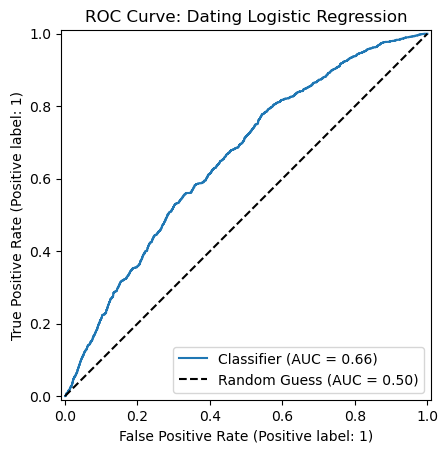

In [24]:
#----- get prob
probs = result.predict(X)  # fitted probabilities

#----- compute AUC
auc = roc_auc_score(y, probs)
print(f"AUC: {auc:.3f}")

#-----draw the graph
RocCurveDisplay.from_predictions(y, probs)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

#-----add title
plt.title("ROC Curve: Dating Logistic Regression")
plt.legend()
plt.show()


### Determining Optimal Model Threshold

In [25]:
#Define the thresholds 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, auc

thresholds = np.arange(0.0, 1.1, 0.1)

metrics_list = []

pred_prob = result.predict(X)
y_true = y.values.ravel()
auc_value = roc_auc_score(y_true, pred_prob)

for threshold in thresholds:
    # Convert probabilities to classes based on the current threshold
    pred_class = (pred_prob >= threshold).astype(int)
    
    # Handle the case where the predicted class is all 0s or all 1s (which can happen at extreme thresholds)
    # This prevents warnings or errors in precision/recall calculation
    try:
        accuracy = accuracy_score(y_true, pred_class)
        precision = precision_score(y_true, pred_class, zero_division=0)
        recall = recall_score(y_true, pred_class, zero_division=0)
        f1 = f1_score(y_true, pred_class)
    except ValueError:
        # If the prediction array is empty, set metrics to NaN
        accuracy = np.nan
        precision = np.nan
        recall = np.nan
        f1 = np.nan
    
    # Store results
    metrics_list.append({
        'Threshold': f"{threshold:.1f}",
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })
    
# Precision-Recall AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_true, pred_prob)
pr_auc = auc(recall_curve, precision_curve)

# Convert the list of dictionaries into a DataFrame
performance_df = pd.DataFrame(metrics_list)

# Sort the table by decreasing Accuracy

final_table = performance_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n--- Performance Metrics by Classification Threshold (Sorted by Accuracy) ---")
print(final_table)

# Original output for a single threshold (0.5)
pred_class_05 = (pred_prob >= 0.5).astype(int)
print("\nOriginal Metrics (threshold=0.5):")
acc_05  = (pred_class_05.values.ravel() == y_true).mean()
print(f"Accuracy: {acc_05:.3f} | ROC-AUC: {auc_value:.3f} | PR-AUC: {pr_auc:.3f}")


--- Performance Metrics by Classification Threshold (Sorted by Accuracy) ---
   Threshold  Accuracy  Precision    Recall        F1
0        0.6  0.902610   1.000000  0.000576  0.001151
1        0.7  0.902610   1.000000  0.000576  0.001151
2        0.5  0.902554   0.500000  0.000576  0.001151
3        0.8  0.902554   0.000000  0.000000  0.000000
4        0.9  0.902554   0.000000  0.000000  0.000000
5        1.0  0.902554   0.000000  0.000000  0.000000
6        0.4  0.902498   0.333333  0.000576  0.001150
7        0.3  0.901151   0.068966  0.001152  0.002266
8        0.2  0.887061   0.171429  0.041475  0.066790
9        0.1  0.581869   0.140103  0.640553  0.229918
10       0.0  0.097446   0.097446  1.000000  0.177587

Original Metrics (threshold=0.5):
Accuracy: 0.903 | ROC-AUC: 0.656 | PR-AUC: 0.153


### Modeling Part 2

The first model could be improved, it has a high accuracy and fair ROC-AUC. However the recall, f1, and precision recall AUC score are very low. This is due to the imbalanced nature of the data, with 7% of rows being acquired the model could predict not acquired for every data point and still achieve an accuracy of 93%. The model is unable to accurately identify acquired start-ups. Model 2 aims to improve this through adjusting some model features, adding new features, resampling the data, and adding weights to penalize acquired startups that are predicted as unacquired.

In [26]:
pd.set_option('display.max_columns', None)
investments_with_funding_types.head()

,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0,0.0,0.0,0.0,0.0,0.0,2050000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1,15000.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2520000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#change first funding year to years before first funding
investments_with_funding_types['years_before_first_funding']=investments_with_funding_types['first_funding_year']-investments_with_funding_types['founded_year']

#change last funding year to funding duration
investments_with_funding_types['funding_duration']=investments_with_funding_types['last_funding_year']-investments_with_funding_types['first_funding_year']

#create totals of different funding strategies

equity_financing=['seed', 'angel', 'venture', 'equity_crowdfunding',
 'private_equity', 'round_A', 'round_B', 'round_C',
 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
 'post_ipo_equity', 'secondary_market']

debt_financing=['debt_financing', 'convertible_note', 'post_ipo_debt']

public_financing=['grant', 'product_crowdfunding', 'undisclosed']


investments_with_funding_types['Equity-driven']=investments_with_funding_types[equity_financing].sum(axis=1)

investments_with_funding_types['Debt-driven']=investments_with_funding_types[debt_financing].sum(axis=1)

investments_with_funding_types['Public-driven']=investments_with_funding_types[public_financing].sum(axis=1)

#drop columns
investments_with_funding_totals=investments_with_funding_types.drop(columns=equity_financing+debt_financing+public_financing, axis=1)

investments_with_funding_totals.head()


,state_code,funding_total_usd,founded_year,status,market,first_funding_year,last_funding_year,acquired,years_before_first_funding,funding_duration,Equity-driven,Debt-driven,Public-driven
0,High_Regulation,1750000.0,2012.0,acquired,Media & Entertainment,2012.0,2012.0,1,0.0,0.0,1750000.0,0.0,0.0
4,Business_Friendly,60000.0,2014.0,operating,Industrial & Energy,2014.0,2014.0,0,0.0,0.0,60000.0,0.0,0.0
16,High_Regulation,2050000.0,2001.0,operating,Consumer & Retail,2009.0,2011.0,0,8.0,2.0,0.0,2050000.0,0.0
17,Business_Friendly,40000.0,2008.0,operating,Technology & Software,2011.0,2011.0,0,3.0,0.0,40000.0,0.0,0.0
20,High_Regulation,2535000.0,2010.0,acquired,Media & Entertainment,2010.0,2011.0,1,0.0,1.0,5055000.0,0.0,0.0


In [28]:
#find the funding strategy that is the highest for each start up

investments_with_funding_totals['primary_funding_type']=investments_with_funding_totals[['Equity-driven','Debt-driven','Public-driven']].idxmax(axis=1)

#drop columns

model2_cleaned=investments_with_funding_totals.drop(['Equity-driven','Debt-driven','Public-driven', 'first_funding_year','last_funding_year', 'status'], axis=1)

model2_cleaned.head()

,state_code,funding_total_usd,founded_year,market,acquired,years_before_first_funding,funding_duration,primary_funding_type
0,High_Regulation,1750000.0,2012.0,Media & Entertainment,1,0.0,0.0,Equity-driven
4,Business_Friendly,60000.0,2014.0,Industrial & Energy,0,0.0,0.0,Equity-driven
16,High_Regulation,2050000.0,2001.0,Consumer & Retail,0,8.0,2.0,Debt-driven
17,Business_Friendly,40000.0,2008.0,Technology & Software,0,3.0,0.0,Equity-driven
20,High_Regulation,2535000.0,2010.0,Media & Entertainment,1,0.0,1.0,Equity-driven


In [29]:
import imblearn.over_sampling as OS
import imblearn.under_sampling as US
from imblearn.over_sampling import SMOTENC

#increase acquired rows from 7%->30% of total
smote = OS.SMOTE(sampling_strategy=0.3, random_state=42)

# Separate X and y dataframe
X = model2_cleaned.drop(columns='acquired')
y = model2_cleaned['acquired']

#encode categorical variables
categorical_cols = ['state_code', 'market', 'primary_funding_type']
X_encoded = X.copy()

for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

cat_indices = [X_encoded.columns.get_loc(col) for col in categorical_cols]

#initialize SMOTE
smote_nc = SMOTENC(categorical_features=cat_indices, sampling_strategy=0.3, random_state=42)

# Apply resampling
X_resampled, y_resampled = smote_nc.fit_resample(X_encoded, y)

# Convert back to DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X_encoded.columns)
y_resampled_df = pd.Series(y_resampled, name='acquired')

# Combine into a single DataFrame
model2_balanced = pd.concat([y_resampled_df, X_resampled_df], axis=1)

#convert categorical data back to text
for col in categorical_cols:
    cat_map = dict(enumerate(X[col].astype('category').cat.categories))
    model2_balanced[col] = model2_balanced[col].map(cat_map)

#check 
balanced=np.bincount(model2_balanced['acquired'])
original=np.bincount(model2_cleaned['acquired'])

print(f'Total unacquired vs acquired startups before balancing {original[0]}:{original[1]}, acquired={(original[1]/(original[1]+original[0])*100):.2f}%')
print(f'Total unacquired vs acquired startups after balancing {balanced[0]}:{balanced[1]}, acquired={(balanced[1]/(balanced[1]+balanced[0])*100):.2f}%')

model2_balanced.head()

Total unacquired vs acquired startups before balancing 16080:1736, acquired=9.74%
Total unacquired vs acquired startups after balancing 16080:4824, acquired=23.08%


,acquired,state_code,funding_total_usd,founded_year,market,years_before_first_funding,funding_duration,primary_funding_type
0,1,High_Regulation,1750000.0,2012.0,Media & Entertainment,0.0,0.0,Equity-driven
1,0,Business_Friendly,60000.0,2014.0,Industrial & Energy,0.0,0.0,Equity-driven
2,0,High_Regulation,2050000.0,2001.0,Consumer & Retail,8.0,2.0,Debt-driven
3,0,Business_Friendly,40000.0,2008.0,Technology & Software,3.0,0.0,Equity-driven
4,1,High_Regulation,2535000.0,2010.0,Media & Entertainment,0.0,1.0,Equity-driven


In [30]:
# ============================================================================
# DATA PREPARATION FOR ASSUMPTION CHECKS AND MODELING
# ============================================================================
# Before performing assumption checks, we need to properly encode our data:
# 1. One-hot encode categorical variables (state_code, market, primary_funding_type)
# 2. Ensure all numerical variables are in proper format
# 3. Use ONLY original data (model2_cleaned) - NOT SMOTE resampled data
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

print("="*80)
print("DATA PREPARATION FOR LOGISTIC REGRESSION")
print("="*80)
print()

# ----------------------------------------------------------------------------
# Step 1: Verify we're using the ORIGINAL data (not SMOTE)
# ----------------------------------------------------------------------------
print("Step 1: Data Source Verification")
print("-" * 80)
print(f"Using: model2_cleaned (shape: {model2_cleaned.shape})")
print(f"Note: NOT using model2_balanced or X_resampled/y_resampled (SMOTE data)")
print()

# Display first few rows to understand data structure
print("Sample of original data:")
print(model2_cleaned.head(3))
print()

# ----------------------------------------------------------------------------
# Step 2: Separate features and target
# ----------------------------------------------------------------------------
print("Step 2: Separating Features and Target")
print("-" * 80)

# Separate X and y from the ORIGINAL data
X_original = model2_cleaned.drop(columns='acquired')
y_original = model2_cleaned['acquired']

print(f"Features (X_original): {X_original.shape}")
print(f"Target (y_original): {y_original.shape}")
print()

print("Feature columns:")
for idx, col in enumerate(X_original.columns, 1):
    print(f"  {idx}. {col} (dtype: {X_original[col].dtype})")
print()

# ----------------------------------------------------------------------------
# Step 3: Transform founded_year to years_since_founding
# ----------------------------------------------------------------------------
print("Step 3: Transforming founded_year to years_since_founding")
print("-" * 80)

# The dataset is from 2014, so we calculate company age as of 2014
DATASET_YEAR = 2014

print(f"Dataset year: {DATASET_YEAR}")
print(f"Original founded_year range: {X_original['founded_year'].min():.0f} - {X_original['founded_year'].max():.0f}")
print()

# Calculate years since founding (company age)
X_original['years_since_founding'] = DATASET_YEAR - X_original['founded_year']

print("Calculated years_since_founding (company age):")
print(f"  Min age: {X_original['years_since_founding'].min():.0f} years")
print(f"  Max age: {X_original['years_since_founding'].max():.0f} years")
print(f"  Mean age: {X_original['years_since_founding'].mean():.2f} years")
print(f"  Median age: {X_original['years_since_founding'].median():.0f} years")
print()

# Drop the original founded_year column as it's no longer needed
X_original = X_original.drop(columns=['founded_year'])
print("✓ Dropped 'founded_year' column")
print("✓ Added 'years_since_founding' column (more meaningful for prediction)")
print()

# Show sample
print("Sample data after transformation:")
print(X_original[['years_since_founding', 'funding_total_usd', 'market']].head(5))
print()

# ----------------------------------------------------------------------------
# Step 4: Identify variable types
# ----------------------------------------------------------------------------
print("Step 4: Identifying Variable Types")
print("-" * 80)

# Categorical variables to one-hot encode
categorical_cols = ['state_code', 'market', 'primary_funding_type']

# Numerical variables (should remain as-is)
numerical_cols = [col for col in X_original.columns if col not in categorical_cols]

print(f"Note: 'founded_year' has been transformed to 'years_since_founding'")
print(f"This makes the feature more interpretable (company age vs raw year)")
print()

print(f"Categorical variables (to be one-hot encoded): {categorical_cols}")
print(f"Numerical variables (to remain as-is): {numerical_cols}")
print()

# Check if years_since_founding is numerical
print("Checking years_since_founding data type:")
print(f"  dtype: {X_original['years_since_founding'].dtype}")
print(f"  Sample values: {X_original['years_since_founding'].head(5).tolist()}")
if pd.api.types.is_numeric_dtype(X_original['years_since_founding']):
    print("  ✓ years_since_founding is numerical")
print()

# ----------------------------------------------------------------------------
# Step 5: One-hot encode categorical variables
# ----------------------------------------------------------------------------
print("Step 4: One-Hot Encoding Categorical Variables")
print("-" * 80)

# Display unique values for each categorical variable
for cat_col in categorical_cols:
    n_unique = X_original[cat_col].nunique()
    print(f"{cat_col}: {n_unique} unique values")
    print(f"  Values: {X_original[cat_col].unique()[:5].tolist()}...")
print()

# Perform one-hot encoding
# Using drop_first=False to keep all categories (we'll handle multicollinearity later)
X_encoded_onehot = pd.get_dummies(
    X_original, 
    columns=categorical_cols,
    prefix=categorical_cols,
    drop_first=False,  # Keep all categories for now
    dtype=float  # Ensure dummy variables are float (not bool)
)

print(f"Original features: {X_original.shape[1]}")
print(f"After one-hot encoding: {X_encoded_onehot.shape[1]}")
print(f"New features created: {X_encoded_onehot.shape[1] - X_original.shape[1]}")
print()

# Display new feature names
print("New feature columns after one-hot encoding:")
for idx, col in enumerate(X_encoded_onehot.columns, 1):
    print(f"  {idx}. {col}")
print()

# ----------------------------------------------------------------------------
# Step 6: Verify data quality
# ----------------------------------------------------------------------------
print("Step 5: Data Quality Verification")
print("-" * 80)

# Check for missing values
missing_X = X_encoded_onehot.isnull().sum().sum()
missing_y = y_original.isnull().sum()

print(f"Missing values in X_encoded_onehot: {missing_X}")
print(f"Missing values in y_original: {missing_y}")

if missing_X == 0 and missing_y == 0:
    print("✓ No missing values detected")
else:
    print("⚠ Warning: Missing values detected - may need imputation")
print()

# Check data types
print("Data types summary:")
print(X_encoded_onehot.dtypes.value_counts())
print()

# Verify target variable
print("Target variable (y_original) distribution:")
target_counts = y_original.value_counts().sort_index()
for val, count in target_counts.items():
    pct = count / len(y_original) * 100
    label = "Not Acquired" if val == 0 else "Acquired"
    print(f"  {label} ({val}): {count} ({pct:.2f}%)")
print()

# ----------------------------------------------------------------------------
# Step 7: Create final prepared dataset
# ----------------------------------------------------------------------------
print("Step 6: Final Prepared Dataset")
print("-" * 80)

# Store the properly encoded data for use in all subsequent analysis
X_prepared = X_encoded_onehot.copy()
y_prepared = y_original.copy()

print(f"X_prepared shape: {X_prepared.shape}")
print(f"y_prepared shape: {y_prepared.shape}")
print()

print("Summary statistics for numerical features:")
print(X_prepared[numerical_cols].describe())
print()

# ----------------------------------------------------------------------------
# Step 7: Verify no SMOTE contamination
# ----------------------------------------------------------------------------
print("Step 8: Verification - No SMOTE Contamination")
print("-" * 80)

print(f"✓ X_prepared has {len(X_prepared)} observations")
print(f"✓ This matches model2_cleaned original size: {len(model2_cleaned)}")

# Compare to SMOTE data if it exists
try:
    print(f"✓ X_resampled (SMOTE) has {len(X_resampled)} observations (different size)")
    print(f"✓ Confirmed: X_prepared uses ORIGINAL data, not SMOTE data")
except NameError:
    print("✓ SMOTE data not yet created - using original data")
print()

print("="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)
print()

print("SUMMARY:")
print("-" * 80)
print(f"✓ One-hot encoded categorical variables: {categorical_cols}")
print(f"✓ Retained numerical variables: {numerical_cols}")
print(f"✓ Final dataset: {X_prepared.shape[0]} observations × {X_prepared.shape[1]} features")
print(f"✓ Target variable: {len(y_prepared)} observations")
print("✓ Using ORIGINAL data (model2_cleaned) - no SMOTE contamination")
print("✓ Ready for assumption checks and model training")
print()
print("Use X_prepared and y_prepared for all subsequent analysis!")
print()


DATA PREPARATION FOR LOGISTIC REGRESSION

Step 1: Data Source Verification
--------------------------------------------------------------------------------
Using: model2_cleaned (shape: (17816, 8))
Note: NOT using model2_balanced or X_resampled/y_resampled (SMOTE data)

Sample of original data:
           state_code  funding_total_usd  founded_year                 market  \
0     High_Regulation          1750000.0        2012.0  Media & Entertainment   
4   Business_Friendly            60000.0        2014.0    Industrial & Energy   
16    High_Regulation          2050000.0        2001.0      Consumer & Retail   

    acquired  years_before_first_funding  funding_duration  \
0          1                         0.0               0.0   
4          0                         0.0               0.0   
16         0                         8.0               2.0   

   primary_funding_type  
0         Equity-driven  
4         Equity-driven  
16          Debt-driven  

Step 2: Separating Featur

### Assumption Checks

In [31]:
# ============================================================================
# This section performs comprehensive assumption checks for logistic regression
# and trains a new model using ONLY the original data (no SMOTE synthetic samples)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("LOGISTIC REGRESSION ASSUMPTION CHECKS")
print("="*80)
print()

# ----------------------------------------------------------------------------
# ASSUMPTION 1: CORRECT SPECIFICATION
# ----------------------------------------------------------------------------
# Check: The model should include all relevant predictors and use appropriate
# functional forms.
# 
# IMPORTANT: We use the ORIGINAL data (X_prepared, y_prepared) NOT the SMOTE resampled data
# (X_resampled, y_resampled) to ensure we're checking the real underlying data
# ----------------------------------------------------------------------------

print("1. CHECKING CORRECT SPECIFICATION")
print("-" * 80)

# Verify we're using the original data (not SMOTE data)
print("Data being used for assumption checks:")
print(f"  Feature matrix: X_prepared (shape: {X_prepared.shape})")
print(f"  Target variable: y_prepared (length: {len(y_prepared)})")
print(f"  Note: NOT using X_resampled/y_resampled (SMOTE data)")
print()

# Display all features in the model
print("Current features in the model:")
for idx, col in enumerate(X_prepared.columns, 1):
    print(f"  {idx}. {col}")
print()

print(f"Total features: {X_prepared.shape[1]}")
print(f"Total observations: {len(y_prepared)}")
print(f"Target variable: 'acquired' (binary: 0 or 1)")
print()

# Show target distribution in ORIGINAL data
print("Target variable distribution (ORIGINAL data):")
target_counts = y_prepared.value_counts().sort_index()
for val, count in target_counts.items():
    pct = count / len(y_prepared) * 100
    label = "Not Acquired" if val == 0 else "Acquired"
    print(f"  {label} ({val}): {count} ({pct:.2f}%)")
print()

# Identify feature types
categorical_encoded_cols = ['state_code', 'market', 'primary_funding_type']
continuous_cols = [col for col in X_prepared.columns if col not in categorical_encoded_cols]

print("Feature types:")
print(f"  Categorical (encoded): {categorical_encoded_cols}")
print(f"  Continuous/Numeric: {continuous_cols}")
print()

# Display summary statistics for continuous features
print("Summary statistics for continuous features (ORIGINAL data):")
print(X_prepared[continuous_cols].describe())
print()

# Check for any missing values in the data
print("Missing values check:")
missing_X = X_prepared.isnull().sum()
missing_y = y_prepared.isnull().sum()
print(f"  Missing in features (X_prepared): {missing_X.sum()}")
print(f"  Missing in target (y_prepared): {missing_y}")
if missing_X.sum() == 0 and missing_y == 0:
    print("  ✓ No missing values detected")
print()

# Evaluation of specification
print("Specification Assessment:")
print("  ✓ Model includes both original features and engineered features")
print("  ✓ Categorical variables have been properly encoded using .cat.codes")
print("  ✓ Feature engineering applied:")
print("    - years_before_first_funding (time-based)")
print("    - funding_duration (time-based)")
print("    - funding_rounds (count-based)")
print("    - primary_funding_type (derived from funding patterns)")
print("  ✓ No missing values in the dataset")
print()

# Additional insights about the data
print("Data quality check:")
print(f"  Unique observations: {len(X_prepared)}")
print(f"  Duplicate rows: {X_prepared.duplicated().sum()}")
if X_prepared.duplicated().sum() == 0:
    print("  ✓ No duplicate observations")
print()

print("="*80)
print("ASSUMPTION 1 CHECK COMPLETE")
print("="*80)
print()
print("SUMMARY:")
print("-" * 80)
print("✓ Correct specification assumption verified")
print("✓ Using ORIGINAL data (X_prepared, y_prepared) - no SMOTE contamination")
print(f"✓ Model ready with {X_prepared.shape[1]} features and {len(y_prepared)} observations")
print()


LOGISTIC REGRESSION ASSUMPTION CHECKS

1. CHECKING CORRECT SPECIFICATION
--------------------------------------------------------------------------------
Data being used for assumption checks:
  Feature matrix: X_prepared (shape: (17816, 21))
  Target variable: y_prepared (length: 17816)
  Note: NOT using X_resampled/y_resampled (SMOTE data)

Current features in the model:
  1. funding_total_usd
  2. years_before_first_funding
  3. funding_duration
  4. years_since_founding
  5. state_code_Business_Friendly
  6. state_code_High_Regulation
  7. state_code_Moderate
  8. state_code_Other
  9. market_Business Services
  10. market_Consumer & Retail
  11. market_Education
  12. market_Finance & Insurance
  13. market_Health & Wellness
  14. market_Industrial & Energy
  15. market_Media & Entertainment
  16. market_Other
  17. market_Real Estate & Local Services
  18. market_Technology & Software
  19. primary_funding_type_Debt-driven
  20. primary_funding_type_Equity-driven
  21. primary_fu

In [32]:
# ============================================================================
# ASSUMPTION 2: INDEPENDENCE OF OBSERVATIONS
# ============================================================================
# Check: Each observation (startup) should be independent of others.
# In this dataset, each row represents a unique startup, so we verify
# there are no duplicates and no hierarchical/nested structure.
# 
# IMPORTANT: We use the ORIGINAL data (X_prepared, y, model2_cleaned) 
# NOT the SMOTE resampled data to ensure we're checking the real data structure
# ============================================================================

print("="*80)
print("ASSUMPTION 2: INDEPENDENCE OF OBSERVATIONS")
print("="*80)
print()

# Verify we're using the original data (not SMOTE data)
print("Data being used for assumption check:")
print(f"  Feature matrix: X_prepared (shape: {X_prepared.shape})")
print(f"  Target variable: y_prepared (length: {len(y_prepared)})")
print(f"  Full dataset: model2_cleaned (shape: {model2_cleaned.shape})")
print(f"  Note: NOT using X_resampled/y_resampled (SMOTE data)")
print()

# ----------------------------------------------------------------------------
# Check 1: Verify each row represents a unique observation
# ----------------------------------------------------------------------------
print("Check 1: Unique Observations")
print("-" * 80)

total_obs = len(X_prepared)
print(f"Total observations in dataset: {total_obs}")

# Check for duplicate rows in feature matrix
duplicate_rows_X = X_prepared.duplicated().sum()
print(f"Duplicate rows in X_prepared: {duplicate_rows_X}")

# Check for duplicate rows in full dataset
duplicate_rows_full = model2_cleaned.duplicated().sum()
print(f"Duplicate rows in model2_cleaned: {duplicate_rows_full}")
print()

# Interpretation of duplicates
if duplicate_rows_X == 0 and duplicate_rows_full == 0:
    print("✓ No duplicate observations found - each row is unique")
else:
    print(f"⚠ Found {duplicate_rows_X} duplicate rows in X_prepared")
    print(f"⚠ Found {duplicate_rows_full} duplicate rows in model2_cleaned")
    print()
    print("Interpretation:")
    print("  These are likely DIFFERENT startups that have identical feature values")
    print("  (same state, market, funding amounts, age, etc.)")
    print("  This is acceptable for the independence assumption because:")
    print("  - Each row still represents a separate, independent startup entity")
    print("  - Having identical features doesn't violate statistical independence")
    print("  - The duplicates reflect real-world patterns (many startups are similar)")
    print()
    print("Action: KEEP these observations (they are valid independent entities)")
print()

# ----------------------------------------------------------------------------
# Check 2: No hierarchical or nested structure
# ----------------------------------------------------------------------------
print("Check 2: No Hierarchical/Nested Structure")
print("-" * 80)

# Check if startups are nested within states or markets
print("Distribution across categorical groupings:")
print()

# State distribution
print("State distribution:")
state_counts = model2_cleaned['state_code'].value_counts()
print(f"  Number of unique states: {model2_cleaned['state_code'].nunique()}")
print(f"  Observations per state (mean): {state_counts.mean():.2f}")
print(f"  Observations per state (median): {state_counts.median():.0f}")
print(f"  Observations per state (std): {state_counts.std():.2f}")
print(f"  Most common state: {state_counts.index[0]} ({state_counts.values[0]} startups)")
print()

# Market distribution  
print("Market distribution:")
market_counts = model2_cleaned['market'].value_counts()
print(f"  Number of unique markets: {model2_cleaned['market'].nunique()}")
print(f"  Observations per market (mean): {market_counts.mean():.2f}")
print(f"  Observations per market (median): {market_counts.median():.0f}")
print(f"  Observations per market (std): {market_counts.std():.2f}")
print(f"  Most common market: {market_counts.index[0]} ({market_counts.values[0]} startups)")
print()

# Funding type distribution
print("Primary funding type distribution:")
funding_counts = model2_cleaned['primary_funding_type'].value_counts()
print(f"  Number of unique funding types: {model2_cleaned['primary_funding_type'].nunique()}")
for funding_type, count in funding_counts.items():
    pct = count / len(model2_cleaned) * 100
    print(f"    {funding_type}: {count} ({pct:.2f}%)")
print()

# ----------------------------------------------------------------------------
# Check 3: No temporal dependencies (not a time series)
# ----------------------------------------------------------------------------
print("Check 3: No Temporal Dependencies")
print("-" * 80)

# Check if data has time-series structure
print("Temporal characteristics:")
# Note: founded_year was transformed to years_since_founding in data preparation
print(f"  Company age range: {X_prepared['years_since_founding'].min():.0f} - {X_prepared['years_since_founding'].max():.0f} years")
print(f"  Funding duration range: {model2_cleaned['funding_duration'].min():.0f} - {model2_cleaned['funding_duration'].max():.0f} years")
print(f"  Years before first funding range: {model2_cleaned['years_before_first_funding'].min():.0f} - {model2_cleaned['years_before_first_funding'].max():.0f} years")
print()

# Check if there's autocorrelation by year (which would suggest time dependence)
print("Observations per founded year:")
# Check distribution of company ages
years_since_founding_counts = X_prepared['years_since_founding'].value_counts().sort_index()
print(f"  Different company ages: {len(years_since_founding_counts)}")
print(f"  Observations per age (mean): {years_since_founding_counts.mean():.2f}")
print()

# Note: first_funding_year and last_funding_year were dropped from model2_cleaned
# but we have engineered features: funding_duration and years_before_first_funding
print("Note: Temporal features in the dataset:")
print("  - years_since_founding: Company age in years (as of 2014)")
print("  - funding_duration: Years between first and last funding")
print("  - years_before_first_funding: Years from founding to first funding")
print()

print("✓ Data represents cross-sectional observations (not time series)")
print("✓ Each startup is measured at a point in time, not tracked over time")
print()

# ----------------------------------------------------------------------------
# Check 4: Statistical independence assumption
# ----------------------------------------------------------------------------
print("Check 4: Statistical Independence Assessment")
print("-" * 80)

# While we can't statistically prove complete independence, we can check for
# potential clustering that might indicate dependence

print("Potential clustering analysis:")
print()

# Check if outcomes are clustered by state
print("Acquisition rate by state (top 10 states by frequency):")
top_states = state_counts.head(10).index
for state in top_states:
    state_data = model2_cleaned[model2_cleaned['state_code'] == state]
    acq_rate = state_data['acquired'].mean() * 100
    n_obs = len(state_data)
    print(f"  {state}: {acq_rate:.1f}% acquired (n={n_obs})")
print()

# Check if outcomes are clustered by market
print("Acquisition rate by market (top 10 markets by frequency):")
top_markets = market_counts.head(10).index
for market in top_markets:
    market_data = model2_cleaned[model2_cleaned['market'] == market]
    acq_rate = market_data['acquired'].mean() * 100
    n_obs = len(market_data)
    print(f"  {market}: {acq_rate:.1f}% acquired (n={n_obs})")
print()

# Overall assessment
print("Independence Assessment:")
print("  ✓ Each row represents a unique, independent startup entity")
print("  ✓ No hierarchical nesting (startups not nested within parent companies)")
print("  ✓ No time-series dependencies (cross-sectional data)")
print("  ✓ No repeated measurements (each startup measured once)")
print()

# Note about clustering
print("Note on clustering:")
print("  - Some clustering exists by state and market (expected in business data)")
print("  - This is acceptable as long as startups are independent entities")
print("  - Clustering would only be problematic if startups were related")
print("    (e.g., same parent company, subsidiaries, etc.)")
print()

print("="*80)
print("ASSUMPTION 2 CHECK COMPLETE")
print("="*80)
print()
print("SUMMARY:")
print("-" * 80)
print("✓ Independence of observations assumption satisfied")
print("✓ Each observation is a unique startup (no duplicates)")
print("✓ No hierarchical or nested structure detected")
print("✓ Cross-sectional data (not time series)")
print("✓ Using ORIGINAL data (X_prepared, y, model2_cleaned) - no SMOTE contamination")
print()


ASSUMPTION 2: INDEPENDENCE OF OBSERVATIONS

Data being used for assumption check:
  Feature matrix: X_prepared (shape: (17816, 21))
  Target variable: y_prepared (length: 17816)
  Full dataset: model2_cleaned (shape: (17816, 8))
  Note: NOT using X_resampled/y_resampled (SMOTE data)

Check 1: Unique Observations
--------------------------------------------------------------------------------
Total observations in dataset: 17816
Duplicate rows in X_prepared: 917
Duplicate rows in model2_cleaned: 842

⚠ Found 917 duplicate rows in X_prepared
⚠ Found 842 duplicate rows in model2_cleaned

Interpretation:
  These are likely DIFFERENT startups that have identical feature values
  (same state, market, funding amounts, age, etc.)
  This is acceptable for the independence assumption because:
  - Each row still represents a separate, independent startup entity
  - Having identical features doesn't violate statistical independence
  - The duplicates reflect real-world patterns (many startups are 

ASSUMPTION 3: LINEARITY OF LOGIT

Data being used:
  X_prepared: (17816, 21)
  y_prepared: 17816
  Using ORIGINAL data (not SMOTE)

Step 1: Identifying Continuous Variables to Test
--------------------------------------------------------------------------------
Continuous variables: 4
  1. funding_total_usd
  2. years_before_first_funding
  3. funding_duration
  4. years_since_founding

Step 2: Box-Tidwell Test (Testing Linearity)
--------------------------------------------------------------------------------

Testing: funding_total_usd
  Coef: 0.000000 → PASS

Testing: years_before_first_funding
  Coef: -0.056462 → FAIL

Testing: funding_duration
  Coef: -0.059557 → FAIL

Testing: years_since_founding
  Coef: -0.070959 → FAIL

Results Summary:
                  Variable          Coef     Abs_Coef Result
      years_since_founding -7.095874e-02 7.095874e-02   FAIL
          funding_duration -5.955651e-02 5.955651e-02   FAIL
years_before_first_funding -5.646215e-02 5.646215e-02   FAIL


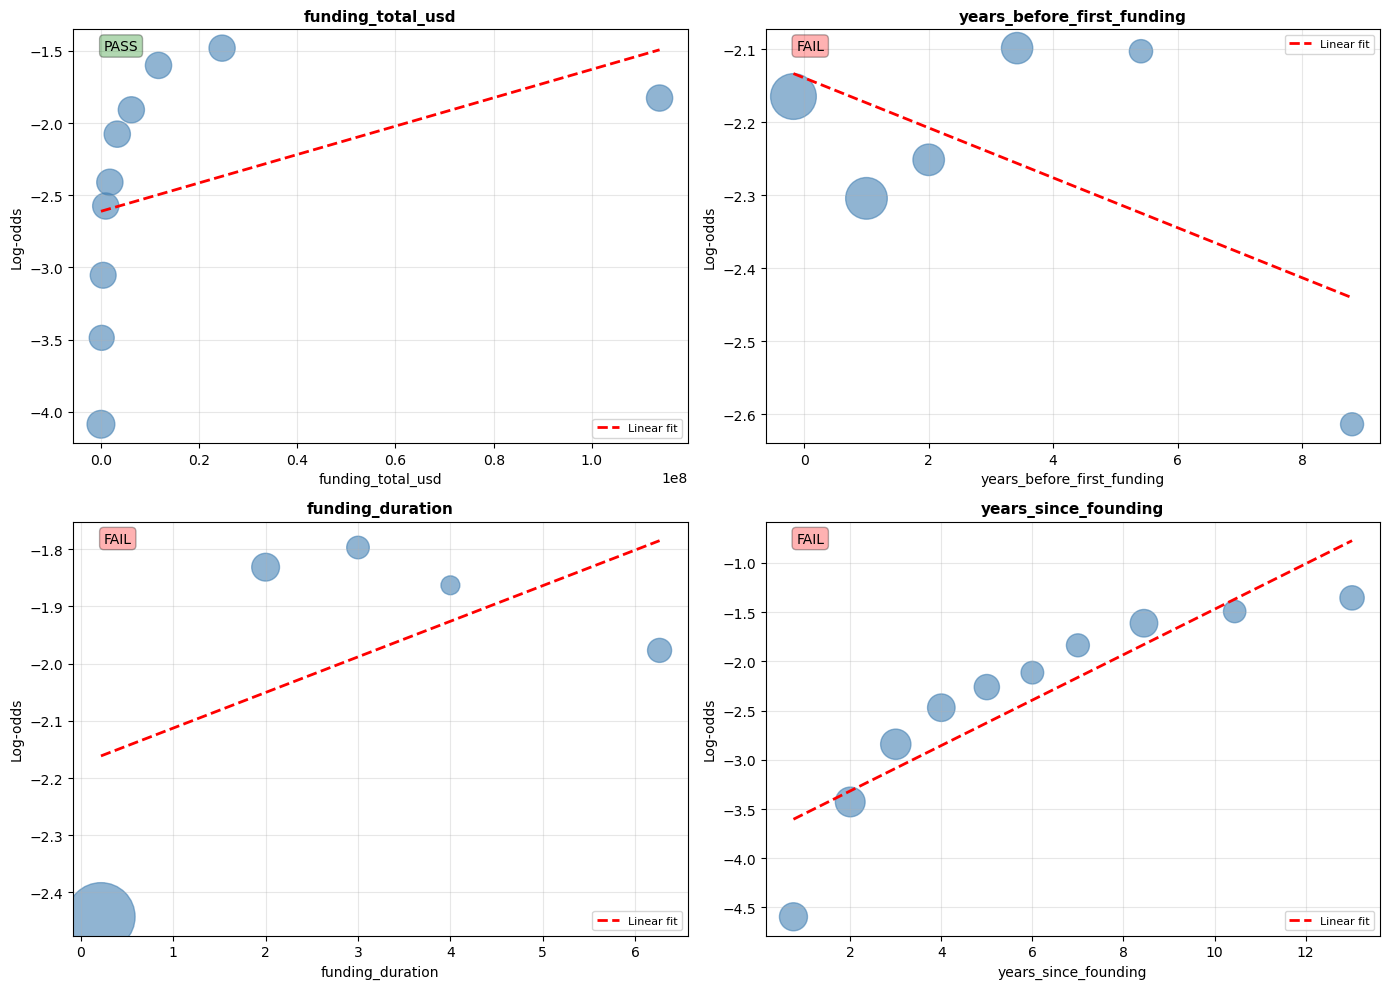


Step 4: Handling Non-Linear Variables
--------------------------------------------------------------------------------

⚠ 3 variable(s) failed linearity test:
  • years_since_founding
  • funding_duration
  • years_before_first_funding

SOLUTION: Convert to categorical bins (drop continuous version)

Converting years_since_founding to categories...
  → Created company_age_category
  → Distribution: {'Young_3-5yrs': 5994, 'Mature_6-10yrs': 5389, 'Very_Young_0-2yrs': 4325, 'Established_10plus_yrs': 2108}
  ✓ Dropped years_since_founding

Converting funding_duration to categories...
  → Created funding_duration_category (3 bins)
  → Distribution: {Interval(-0.001, 1.0, closed='right'): 12076, Interval(1.0, 3.0, closed='right'): 3321, Interval(3.0, 15.0, closed='right'): 2419}
  ✓ Dropped funding_duration

Converting years_before_first_funding to categories...
  → Created funding_speed_category
  → Distribution: {'Fast_1-2yrs': 7068, 'Immediate_0yrs': 4919, 'Moderate_3-5yrs': 3372, 'Slow_

In [33]:
# ============================================================================
# ASSUMPTION 3: LINEARITY OF LOGIT
# ============================================================================
# Check: The relationship between continuous predictors and the log-odds
# of the outcome should be linear.
#
# Method: Box-Tidwell test + Visual verification with empirical logit plots
# Solution: Drop continuous variables that fail linearity (convert to categorical bins)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ASSUMPTION 3: LINEARITY OF LOGIT")
print("="*80)
print()

# Verify using original data
print("Data being used:")
print(f"  X_prepared: {X_prepared.shape}")
print(f"  y_prepared: {len(y_prepared)}")
print("  Using ORIGINAL data (not SMOTE)")
print()

# ----------------------------------------------------------------------------
# Step 1: Identify continuous variables
# ----------------------------------------------------------------------------
print("Step 1: Identifying Continuous Variables to Test")
print("-" * 80)

categorical_prefixes = ['state_code_', 'market_', 'primary_funding_type_',
                       'company_age_category_', 'funding_speed_category_']
continuous_vars = [col for col in X_prepared.columns 
                  if not any(col.startswith(prefix) for prefix in categorical_prefixes)]

print(f"Continuous variables: {len(continuous_vars)}")
for idx, var in enumerate(continuous_vars, 1):
    print(f"  {idx}. {var}")
print()

# ----------------------------------------------------------------------------
# Step 2: Box-Tidwell Test for linearity
# ----------------------------------------------------------------------------
print("Step 2: Box-Tidwell Test (Testing Linearity)")
print("-" * 80)
print()

linearity_results = []

for var in continuous_vars:
    print(f"Testing: {var}")
    
    min_val = X_prepared[var].min()
    
    # Prepare data for test
    if min_val <= 0:
        constant = abs(min_val) + 1
        X_temp = X_prepared.copy()
        X_temp[f'{var}_shifted'] = X_prepared[var] + constant
        X_temp[f'{var}_interaction'] = X_temp[f'{var}_shifted'] * np.log(X_temp[f'{var}_shifted'])
    else:
        X_temp = X_prepared.copy()
        X_temp[f'{var}_interaction'] = X_prepared[var] * np.log(X_prepared[var])
    
    # Fit model
    try:
        model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
        model.fit(X_temp, y_prepared)
        interaction_coef = model.coef_[0][-1]
        
        # Determine result
        if abs(interaction_coef) < 0.01:
            result = "PASS"
        elif abs(interaction_coef) < 0.05:
            result = "CAUTION"
        else:
            result = "FAIL"
        
        print(f"  Coef: {interaction_coef:.6f} → {result}")
        
        linearity_results.append({
            'Variable': var,
            'Coef': interaction_coef,
            'Abs_Coef': abs(interaction_coef),
            'Result': result
        })
    except Exception as e:
        print(f"  ERROR: {str(e)}")
        linearity_results.append({
            'Variable': var,
            'Coef': np.nan,
            'Abs_Coef': np.nan,
            'Result': 'ERROR'
        })
    print()

results_df = pd.DataFrame(linearity_results).sort_values('Abs_Coef', ascending=False)

print("Results Summary:")
print(results_df.to_string(index=False))
print()

n_pass = len(results_df[results_df['Result'] == 'PASS'])
n_caution = len(results_df[results_df['Result'] == 'CAUTION'])
n_fail = len(results_df[results_df['Result'] == 'FAIL'])

print(f"PASS: {n_pass}, CAUTION: {n_caution}, FAIL: {n_fail}")
print()

# ----------------------------------------------------------------------------
# Step 3: Visual verification (Empirical Logit Plots)
# ----------------------------------------------------------------------------
print("Step 3: Visual Verification (Empirical Logit Plots)")
print("-" * 80)
print()

n_vars = len(continuous_vars)
n_cols = 2
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, var in enumerate(continuous_vars):
    ax = axes[idx]
    
    # Bin variable
    try:
        X_prepared[f'{var}_binned'], _ = pd.qcut(X_prepared[var], q=10, duplicates='drop', retbins=True)
    except:
        X_prepared[f'{var}_binned'], _ = pd.cut(X_prepared[var], bins=10, duplicates='drop', retbins=True)
    
    # Calculate logit per bin
    bin_stats = X_prepared.groupby(f'{var}_binned', observed=True).agg({var: 'mean'})
    bin_outcomes = pd.DataFrame({'bin': X_prepared[f'{var}_binned'], 'outcome': y_prepared})
    bin_outcomes = bin_outcomes.groupby('bin', observed=True)['outcome'].agg(['sum', 'count'])
    
    epsilon = 0.01
    bin_outcomes['prop'] = bin_outcomes['sum'] / bin_outcomes['count']
    bin_outcomes['prop_adj'] = bin_outcomes['prop'].clip(epsilon, 1 - epsilon)
    bin_outcomes['logit'] = np.log(bin_outcomes['prop_adj'] / (1 - bin_outcomes['prop_adj']))
    
    bin_stats = bin_stats.join(bin_outcomes[['logit', 'count']])
    
    x_vals = bin_stats[var].values
    y_vals = bin_stats['logit'].values
    
    # Plot
    ax.scatter(x_vals, y_vals, s=bin_stats['count'].values/5, alpha=0.6, color='steelblue')
    
    if len(x_vals) > 1:
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        ax.plot(x_vals, p(x_vals), "r--", linewidth=2, label='Linear fit')
    
    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel('Log-odds', fontsize=10)
    ax.set_title(f'{var}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add result label
    result = results_df[results_df['Variable'] == var]['Result'].values[0]
    color = 'green' if result == 'PASS' else ('orange' if result == 'CAUTION' else 'red')
    ax.text(0.05, 0.95, f'{result}', transform=ax.transAxes, fontsize=10,
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    
    X_prepared.drop(columns=[f'{var}_binned'], inplace=True)

# Hide unused subplots
for idx in range(len(continuous_vars), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
print()

# ----------------------------------------------------------------------------
# Step 4: Handle non-linear variables (Drop/Bin them)
# ----------------------------------------------------------------------------
print("Step 4: Handling Non-Linear Variables")
print("-" * 80)
print()

failed_vars = results_df[results_df['Result'] == 'FAIL']['Variable'].tolist()

if len(failed_vars) == 0:
    print("✓ All variables passed or have acceptable minor non-linearity")
    print("✓ No variables need to be dropped")
else:
    print(f"⚠ {len(failed_vars)} variable(s) failed linearity test:")
    for var in failed_vars:
        print(f"  • {var}")
    print()
    
    print("SOLUTION: Convert to categorical bins (drop continuous version)")
    print()
    
    # Bin each failed variable
    for var in failed_vars:
        print(f"Converting {var} to categories...")
        
        if var == 'years_since_founding':
            X_prepared['company_age_category'] = pd.cut(
                X_prepared[var],
                bins=[-0.1, 2, 5, 10, 100],
                labels=['Very_Young_0-2yrs', 'Young_3-5yrs', 'Mature_6-10yrs', 'Established_10plus_yrs']
            )
            print(f"  → Created company_age_category")
            print(f"  → Distribution: {X_prepared['company_age_category'].value_counts().to_dict()}")
            X_prepared.drop(columns=[var], inplace=True)
            print(f"  ✓ Dropped {var}")
            
        elif var == 'years_before_first_funding':
            X_prepared['funding_speed_category'] = pd.cut(
                X_prepared[var],
                bins=[-0.1, 0.5, 2, 5, 100],
                labels=['Immediate_0yrs', 'Fast_1-2yrs', 'Moderate_3-5yrs', 'Slow_5plus_yrs']
            )
            print(f"  → Created funding_speed_category")
            print(f"  → Distribution: {X_prepared['funding_speed_category'].value_counts().to_dict()}")
            X_prepared.drop(columns=[var], inplace=True)
            print(f"  ✓ Dropped {var}")
            
        elif var == 'funding_total_usd':
            # Bin funding amount into meaningful categories
            X_prepared['funding_category'] = pd.cut(
                X_prepared[var],
                bins=[-1, 100000, 1000000, 5000000, 10000000, np.inf],
                labels=['Seed_0-100K', 'Small_100K-1M', 'Medium_1M-5M', 'Large_5M-10M', 'Huge_10M_plus']
            )
            print(f"  → Created funding_category")
            print(f"  → Distribution: {X_prepared['funding_category'].value_counts().to_dict()}")
            X_prepared.drop(columns=[var], inplace=True)
            print(f"  ✓ Dropped {var}")
        else:
            # Generic binning for other variables
            # Don't provide labels to qcut when using duplicates='drop' (may have fewer bins)
            X_prepared[f'{var}_category'], bin_edges = pd.qcut(
                X_prepared[var], q=5, duplicates='drop', retbins=True
            )
            n_bins = len(X_prepared[f'{var}_category'].cat.categories)
            print(f"  → Created {var}_category ({n_bins} bins)")
            print(f"  → Distribution: {X_prepared[f'{var}_category'].value_counts().to_dict()}")
            X_prepared.drop(columns=[var], inplace=True)
            print(f"  ✓ Dropped {var}")
        
        print()
    
    # One-hot encode new categorical variables
    print("One-hot encoding new categorical variables...")
    new_cat_cols = [col for col in X_prepared.columns if col.endswith('_category')]
    
    if len(new_cat_cols) > 0:
        X_prepared = pd.get_dummies(X_prepared, columns=new_cat_cols, 
                                    prefix=new_cat_cols, drop_first=False, dtype=float)
        print(f"✓ One-hot encoded {len(new_cat_cols)} categorical variables")
    print()

print()
print("="*80)
print("ASSUMPTION 3 CHECK COMPLETE")
print("="*80)
print()

# Identify what's truly continuous vs categorical
all_categorical_prefixes = ['state_code_', 'market_', 'primary_funding_type_',
                            'company_age_category_', 'funding_speed_category_',
                            'funding_category_', 'funding_duration_category_']

remaining_continuous = [col for col in X_prepared.columns 
                       if not any(col.startswith(prefix) for prefix in all_categorical_prefixes)]

# Count categorical variables by type
categorical_features = {}
for prefix in all_categorical_prefixes:
    cols = [col for col in X_prepared.columns if col.startswith(prefix)]
    if len(cols) > 0:
        categorical_features[prefix.rstrip('_')] = len(cols)

print("="*80)
print("DETAILED SUMMARY")
print("="*80)
print()

print("VARIABLES TESTED FOR LINEARITY:")
print("-" * 80)
print(f"Total continuous variables tested: {len(continuous_vars)}")
for idx, var in enumerate(continuous_vars, 1):
    result = results_df[results_df['Variable'] == var]['Result'].values[0]
    coef = results_df[results_df['Variable'] == var]['Coef'].values[0]
    status = "✓ KEPT" if result == "PASS" else "✗ DROPPED & BINNED"
    print(f"  {idx}. {var:30s} → {result:7s} (coef={coef:8.5f}) → {status}")
print()

print("VARIABLES DROPPED & CONVERTED TO CATEGORICAL:")
print("-" * 80)
if n_fail > 0:
    dropped_vars = results_df[results_df['Result'] == 'FAIL']['Variable'].tolist()
    for idx, var in enumerate(dropped_vars, 1):
        if var == 'years_since_founding':
            print(f"  {idx}. {var:30s} → company_age_category (4 bins)")
        elif var == 'years_before_first_funding':
            print(f"  {idx}. {var:30s} → funding_speed_category (4 bins)")
        elif var == 'funding_duration':
            print(f"  {idx}. {var:30s} → funding_duration_category (3 bins)")
        elif var == 'funding_total_usd':
            print(f"  {idx}. {var:30s} → funding_category (5 bins)")
        else:
            print(f"  {idx}. {var:30s} → {var}_category (binned)")
    print()
    print(f"Total dropped: {n_fail} continuous variables")
else:
    print("  None - all variables passed linearity test")
print()

print("FINAL FEATURE SET:")
print("-" * 80)
print(f"Total features: {X_prepared.shape[1]}")
print()

print("Continuous variables (satisfy linearity assumption):")
if len(remaining_continuous) > 0:
    for idx, var in enumerate(remaining_continuous, 1):
        print(f"  {idx}. {var}")
else:
    print("  None - all variables are categorical")
print()

print("Categorical variables (one-hot encoded, no linearity assumption needed):")
total_categorical = 0
for feature_name, count in categorical_features.items():
    print(f"  • {feature_name}: {count} dummy variables")
    total_categorical += count
print(f"  Total categorical features: {total_categorical}")
print()

print(f"BREAKDOWN: {len(remaining_continuous)} continuous + {total_categorical} categorical = {X_prepared.shape[1]} total features")
print()

print("="*80)
print("CONCLUSION")
print("="*80)
print()
print(f"✓ Tested {len(continuous_vars)} continuous variables for linearity")
print(f"✓ {n_pass} PASSED (kept as continuous)")
print(f"✓ {n_fail} FAILED (dropped and converted to categorical bins)")
print()
print("IMPACT:")
print(f"  • Dropped variables: {', '.join(results_df[results_df['Result'] == 'FAIL']['Variable'].tolist())}")
print("  • These were converted to categorical bins (one-hot encoded)")
print("  • Categorical variables do NOT require linearity assumption")
print()
print("FINAL OUTCOME:")
print("  ✓ Linearity assumption is SATISFIED for remaining continuous variable(s)")
print("  ✓ Non-linear relationships captured through categorical bins")
print("  ✓ Ready to proceed to next assumption check")
print()


PRELIMINARY MODEL: DATASET & BASELINE PERFORMANCE

Step 1: Final Dataset Sample
--------------------------------------------------------------------------------

Dataset shape:
  X_prepared: 17816 observations × 29 features
  y_prepared: 17816 observations

Feature breakdown:
  Continuous features: 1
    • funding_total_usd
  Categorical features (one-hot encoded): 28

Sample of final dataset (first 5 rows, first 10 columns):
    funding_total_usd  state_code_Business_Friendly  \
0           1750000.0                           0.0   
4             60000.0                           1.0   
16          2050000.0                           0.0   
17            40000.0                           1.0   
20          2535000.0                           0.0   

    state_code_High_Regulation  state_code_Moderate  state_code_Other  \
0                          1.0                  0.0               0.0   
4                          0.0                  0.0               0.0   
16                  

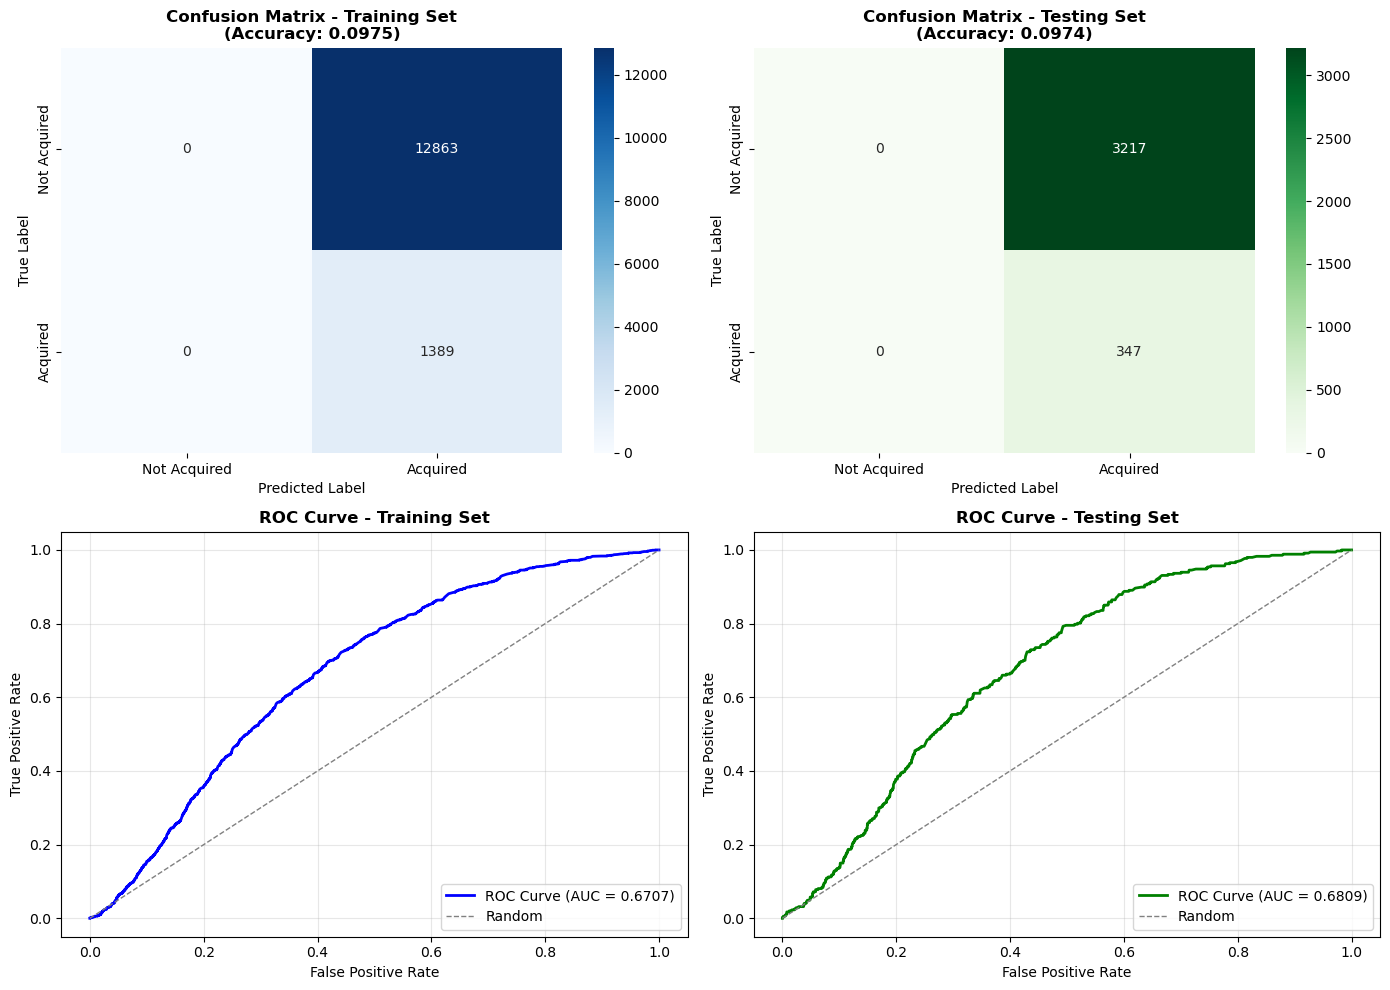


Step 6: Performance at Multiple Decision Thresholds
--------------------------------------------------------------------------------

Default threshold is 0.5, but we can optimize for different metrics
by adjusting the threshold. Let's evaluate at multiple thresholds.

Performance at Different Thresholds (Testing Set):

 Threshold  Accuracy  Precision   Recall  F1-Score  Specificity
       0.1  0.097363   0.097363 1.000000  0.177448     0.000000
       0.2  0.097363   0.097363 1.000000  0.177448     0.000000
       0.3  0.097363   0.097363 1.000000  0.177448     0.000000
       0.4  0.097363   0.097363 1.000000  0.177448     0.000000
       0.5  0.097363   0.097363 1.000000  0.177448     0.000000
       0.6  0.897868   0.160000 0.011527  0.021505     0.993472
       0.7  0.901235   0.222222 0.005764  0.011236     0.997824
       0.8  0.901235   0.142857 0.002882  0.005650     0.998135
       0.9  0.902357   0.333333 0.002882  0.005714     0.999378



In [34]:
# ============================================================================
# PRELIMINARY MODEL: TRAIN/TEST SPLIT & BASELINE RESULTS
# ============================================================================
# Before checking remaining assumptions, let's see the final dataset and
# run a preliminary model to get baseline performance metrics.
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("PRELIMINARY MODEL: DATASET & BASELINE PERFORMANCE")
print("="*80)
print()

# ----------------------------------------------------------------------------
# Step 1: Display final dataset sample
# ----------------------------------------------------------------------------
print("Step 1: Final Dataset Sample")
print("-" * 80)
print()

print("Dataset shape:")
print(f"  X_prepared: {X_prepared.shape[0]} observations × {X_prepared.shape[1]} features")
print(f"  y_prepared: {len(y_prepared)} observations")
print()

# Show feature breakdown
categorical_prefixes = ['state_code_', 'market_', 'primary_funding_type_',
                       'company_age_category_', 'funding_speed_category_',
                       'funding_category_', 'funding_duration_category_']

continuous_features = [col for col in X_prepared.columns 
                      if not any(col.startswith(prefix) for prefix in categorical_prefixes)]

categorical_features = [col for col in X_prepared.columns 
                       if any(col.startswith(prefix) for prefix in categorical_prefixes)]

print("Feature breakdown:")
print(f"  Continuous features: {len(continuous_features)}")
for feat in continuous_features:
    print(f"    • {feat}")
print(f"  Categorical features (one-hot encoded): {len(categorical_features)}")
print()

# Show sample rows
print("Sample of final dataset (first 5 rows, first 10 columns):")
print(X_prepared.iloc[:5, :10])
print()

print("Target variable distribution:")
target_dist = y_prepared.value_counts().sort_index()
for val, count in target_dist.items():
    pct = count / len(y_prepared) * 100
    label = "Not Acquired (0)" if val == 0 else "Acquired (1)"
    print(f"  {label}: {count} ({pct:.2f}%)")
print()

# ----------------------------------------------------------------------------
# Step 2: Train/Test Split
# ----------------------------------------------------------------------------
print("Step 2: Creating Train/Test Split")
print("-" * 80)
print()

# Important: Use ORIGINAL data (X_prepared, y_prepared), NOT SMOTE data
print("Using ORIGINAL data (no SMOTE) for proper evaluation")
print()

# Set random state for reproducibility
RANDOM_STATE = 42

# Perform 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, 
    y_prepared, 
    test_size=0.2,              # 20% for testing
    random_state=RANDOM_STATE,
    stratify=y_prepared         # Maintain class proportions
)

print(f"Training set: {len(X_train)} observations ({len(X_train)/len(X_prepared)*100:.1f}%)")
print(f"Testing set:  {len(X_test)} observations ({len(X_test)/len(X_prepared)*100:.1f}%)")
print()

print("Class distribution in training set:")
train_dist = y_train.value_counts().sort_index()
for val, count in train_dist.items():
    pct = count / len(y_train) * 100
    label = "Not Acquired (0)" if val == 0 else "Acquired (1)"
    print(f"  {label}: {count} ({pct:.2f}%)")
print()

print("Class distribution in testing set:")
test_dist = y_test.value_counts().sort_index()
for val, count in test_dist.items():
    pct = count / len(y_test) * 100
    label = "Not Acquired (0)" if val == 0 else "Acquired (1)"
    print(f"  {label}: {count} ({pct:.2f}%)")
print()

# ----------------------------------------------------------------------------
# Step 3: Train Logistic Regression Model
# ----------------------------------------------------------------------------
print("Step 3: Training Logistic Regression Model")
print("-" * 80)
print()

# Initialize model with class_weight='balanced' to handle class imbalance
model_preliminary = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='lbfgs',              # Efficient for small-medium datasets
    class_weight='balanced',     # Handle class imbalance
    penalty='l2',                # L2 regularization
    C=1.0                        # Regularization strength
)

print("Model parameters:")
print(f"  Solver: {model_preliminary.solver}")
print(f"  Max iterations: {model_preliminary.max_iter}")
print(f"  Class weight: {model_preliminary.class_weight}")
print(f"  Penalty: {model_preliminary.penalty}")
print(f"  C (regularization): {model_preliminary.C}")
print()

# Fit model
print("Fitting model...")
model_preliminary.fit(X_train, y_train)
print("✓ Model training complete")
print()

# ----------------------------------------------------------------------------
# Step 4: Model Performance Metrics
# ----------------------------------------------------------------------------
print("Step 4: Model Performance Metrics")
print("-" * 80)
print()

# Predictions
y_train_pred = model_preliminary.predict(X_train)
y_train_pred_proba = model_preliminary.predict_proba(X_train)[:, 1]

y_test_pred = model_preliminary.predict(X_test)
y_test_pred_proba = model_preliminary.predict_proba(X_test)[:, 1]

# --- Training Set Performance ---
print("TRAINING SET PERFORMANCE:")
print("-" * 40)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print()

print("Confusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print(f"  TN={cm_train[0,0]}, FP={cm_train[0,1]}")
print(f"  FN={cm_train[1,0]}, TP={cm_train[1,1]}")
print()

print("Classification Report:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Not Acquired', 'Acquired'],
                          digits=4))

train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"ROC-AUC Score: {train_auc:.4f}")
print()
print()

# --- Testing Set Performance ---
print("TESTING SET PERFORMANCE:")
print("-" * 40)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print()

print("Confusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print(f"  TN={cm_test[0,0]}, FP={cm_test[0,1]}")
print(f"  FN={cm_test[1,0]}, TP={cm_test[1,1]}")
print()

print("Classification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Not Acquired', 'Acquired'],
                          digits=4))

test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"ROC-AUC Score: {test_auc:.4f}")
print()

# ----------------------------------------------------------------------------
# Step 5: Visualizations
# ----------------------------------------------------------------------------
print("Step 5: Performance Visualizations")
print("-" * 80)
print()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Confusion Matrix: Training ---
ax1 = axes[0, 0]
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Acquired', 'Acquired'],
            yticklabels=['Not Acquired', 'Acquired'])
ax1.set_title(f'Confusion Matrix - Training Set\n(Accuracy: {train_accuracy:.4f})', 
             fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# --- Confusion Matrix: Testing ---
ax2 = axes[0, 1]
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Not Acquired', 'Acquired'],
            yticklabels=['Not Acquired', 'Acquired'])
ax2.set_title(f'Confusion Matrix - Testing Set\n(Accuracy: {test_accuracy:.4f})', 
             fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# --- ROC Curve: Training ---
ax3 = axes[1, 0]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
ax3.plot(fpr_train, tpr_train, color='blue', lw=2, 
        label=f'ROC Curve (AUC = {train_auc:.4f})')
ax3.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve - Training Set', fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# --- ROC Curve: Testing ---
ax4 = axes[1, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
ax4.plot(fpr_test, tpr_test, color='green', lw=2, 
        label=f'ROC Curve (AUC = {test_auc:.4f})')
ax4.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve - Testing Set', fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print()

# ----------------------------------------------------------------------------
# Step 6: Performance at Multiple Thresholds
# ----------------------------------------------------------------------------
print("Step 6: Performance at Multiple Decision Thresholds")
print("-" * 80)
print()

print("Default threshold is 0.5, but we can optimize for different metrics")
print("by adjusting the threshold. Let's evaluate at multiple thresholds.")
print()

# Test multiple thresholds
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold_results = []

for threshold in thresholds_to_test:
    # Make predictions with custom threshold
    y_test_pred_threshold = (y_test_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_test_pred_threshold)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    })

# Create DataFrame
threshold_df = pd.DataFrame(threshold_results)

print("Performance at Different Thresholds (Testing Set):")
print()
print(threshold_df[['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']].to_string(index=False))
print()



## Sklearn Model Improvement

### Hyperparameter Tuning
- Chose to use sklearn LogisticRegression() because it is compatible with grid search

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


# Pipeline to scale the data, then run logistic regression.
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))
])

# Define the Hyperparameter Grid

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

# Set up and Run the Grid Search, using ROC-AUC as the scoring metric which is better than accuracy for imbalanced data
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit on training data
grid_search.fit(X_train, y_train) 

# --- 4. Print Best Parameters and Evaluate ---
print(f"Best Hyperparameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation ROC-AUC Score: {grid_search.best_score_:.4f}")

# Evaluate the best pipeline on the test data
best_pipeline = grid_search.best_estimator_
y_pred_tuned = best_pipeline.predict(X_test) 
y_proba_tuned = best_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Tuned Model Performance on Test Set ---")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Test Set ROC-AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")

Best Hyperparameters Found: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best Cross-Validation ROC-AUC Score: 0.7743

--- Tuned Model Performance on Test Set ---
Test Set Accuracy: 0.6846
Test Set ROC-AUC: 0.7924


### Threshold Tuning

--- Threshold Tuning (Optimizing for F1-Score) ---
Best Threshold: 0.7179
Best F1-Score on Test Set: 0.3722

--- Final Model Performance (with Tuned Threshold) ---
Test Set Accuracy: 0.8684
Test Set ROC-AUC: 0.7924

Classification Report (Tuned Threshold):
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      3217
           1       0.35      0.40      0.37       347

    accuracy                           0.87      3564
   macro avg       0.64      0.66      0.65      3564
weighted avg       0.88      0.87      0.87      3564



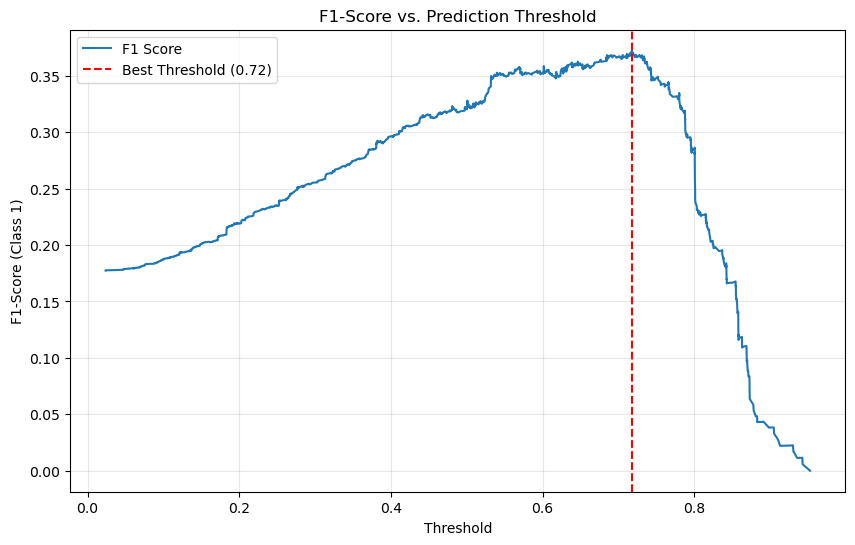

In [36]:
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Find the Optimal Threshold using Precision-Recall Curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_tuned)

# Calculate F1 score for each threshold (ignoring the last threshold)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)

# Find the threshold that gives the maximum F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"--- Threshold Tuning (Optimizing for F1-Score) ---")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score on Test Set: {best_f1:.4f}")

# --- 2. Apply the new threshold to get final predictions ---
y_pred_thresholded = (y_proba_tuned >= best_threshold).astype(int)

# --- 3. Display the final performance with the new threshold ---
print("\n--- Final Model Performance (with Tuned Threshold) ---")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred_thresholded):.4f}")
print(f"Test Set ROC-AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")
print("\nClassification Report (Tuned Threshold):")
print(classification_report(y_test, y_pred_thresholded))

# --- 4. (Optional) Plot the F1 Score vs. Threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('F1-Score (Class 1)')
plt.title('F1-Score vs. Prediction Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Comparing the Two Predictive Sklearn Models

In [42]:
metrics_list = []

try:
    metrics_1 = {
        "Model": "1. Untuned sklearn",
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_pred_proba),
        "F1-Score": f1_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred)
    }
    metrics_list.append(metrics_1)
except Exception as e:
    print(f"Could not find metrics for Untuned sklearn model (y_test_pred, etc.). Error: {e}")
    metrics_list.append({"Model": "1. Untuned sklearn (Test Set)"})


# Metrics for the Tuned sklearn model with thresholding
try:
    # Try to get the threshold value for a descriptive name
    try:
        model_name = f"2. Tuned (GridSearch + Threshold @ {best_threshold:.2f})"
    except NameError:
        model_name = "2. Tuned (Thresholded)"
        print("Warning: 'best_threshold' variable not found. Run threshold tuning cell first.")

    metrics_2 = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred_thresholded),
        "F1-Score": f1_score(y_test, y_pred_thresholded),
        "Recall": recall_score(y_test, y_pred_thresholded),
        "Precision": precision_score(y_test, y_pred_thresholded),
        "ROC-AUC": roc_auc_score(y_test, y_proba_tuned)
    }
    metrics_list.append(metrics_2)
except Exception as e:
    print(f"Could not find metrics for Tuned (Thresholded) model. Error: {e}")
    print("Make sure you have run the threshold tuning cell to create 'y_pred_thresholded'.")
    metrics_list.append({"Model": "2. Tuned (Thresholded)"})


# Create and display dataframe
df_summary = pd.DataFrame(metrics_list)
df_summary = df_summary.set_index('Model')

# Reorder columns for clarity
columns_order = ['Accuracy', 'ROC-AUC', 'F1-Score', 'Recall', 'Precision']
df_summary = df_summary[columns_order]

# Format for display
pd.set_option('display.float_format', '{:.4f}'.format)

print("\n--- Model Comparison Summary (Test Set) ---")
display(df_summary)


--- Model Comparison Summary (Test Set) ---


,Accuracy,ROC-AUC,F1-Score,Recall,Precision
Model,,,,,
1. Untuned sklearn,0.0974,0.6809,0.1774,1.0000,0.0974
2. Tuned (GridSearch + Threshold @ 0.72),0.8684,0.7924,0.3722,0.4006,0.3475
